### Importing All Necessary Libraries

In [2]:
import time, random, math
import pandas as pd
import numpy as np
import openrouteservice
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from deap import base, creator, tools, algorithms
import pyswarms as ps
from pyswarms.single import GlobalBestPSO 
from optalgotools.algorithms import SimulatedAnnealing
from optalgotools.problems.__problem_base import ProblemBase

### DATA PREPROCESSING

#### Load & Prepare Data

In [5]:
df = pd.read_csv("DeliveryDataset2.csv").reset_index(drop=True)
df["CustomerID"] = [f"C{i+1}" for i in df.index]
customers = df["CustomerID"].tolist()
C = len(customers)
drivers    = [f"D{i+1}" for i in range(C)]
num_drivers = len(drivers)
hub_lat, hub_lon = df.loc[0, ["lat","lon"]]   # Depot Coordinates
demand    = dict(zip(df["CustomerID"], df["TotalLoad"]))
capacity   = 50                               # 50 kg each
T_max      = 60                               # max wait (unused here)
shift_min  = 8*60                             # 8 hr shift in minutes
service_tm = 5                                # 5 min service each stop
priority  = dict(zip(
    df.CustomerID,
    df.Priority    if "Priority" in df.columns else np.random.randint(1,6,size=C)
))
wait_time = dict(zip(
    df.CustomerID,
    df.WaitTime    if "WaitTime" in df.columns else np.random.randint(60,61,size=C)
))

#### Distance & Time Matrices

In [7]:


# Setting the OpenRouteService API key here
ors_client = openrouteservice.Client(key='5b3ce3597851110001cf6248693af50d08604b6284270544186cb668')

nodes = ['0'] + df.CustomerID.tolist()

# Constructing coordinate dictionary with consistent keys
coords = {'0': (df.lat[0], df.lon[0])}
for i, row in df.iterrows():
    coords['C' + str(i+1)] = (row.lat, row.lon)

# Function to compute batch distance and time matrices
def batch_distance_matrix(client, locations, batch_size=50):
    num_locations = len(locations)
    distance_matrix = np.zeros((num_locations, num_locations))
    time_matrix = np.zeros((num_locations, num_locations))

    for i in range(0, num_locations, batch_size):
        for j in range(0, num_locations, batch_size):
            sources = list(range(i, min(i+batch_size, num_locations)))
            destinations = list(range(j, min(j+batch_size, num_locations)))

            sub_matrix = client.distance_matrix(
                locations=locations,
                profile='driving-car',
                sources=sources,
                destinations=destinations,
                metrics=['distance', 'duration'],
                units='km'
            )

            for s_idx, s in enumerate(sources):
                for d_idx, d in enumerate(destinations):
                    distance_matrix[s, d] = sub_matrix['distances'][s_idx][d_idx]
                    time_matrix[s, d] = sub_matrix['durations'][s_idx][d_idx] / 60.0

    return distance_matrix, time_matrix

# Prepare coordinates for batch processing
locations = [coords[node][::-1] for node in nodes]

# Get matrices in batches
distance_matrix, time_matrix = batch_distance_matrix(ors_client, locations)

# Convert to dictionary format
dist = {}
time_dist = {}
for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        dist[(u, v)] = distance_matrix[i][j]
        time_dist[(u, v)] = time_matrix[i][j]

# Example usage
dist
time_dist

{('0', '0'): 0.0,
 ('0', 'C1'): 0.0,
 ('0', 'C2'): 15.719666666666665,
 ('0', 'C3'): 11.185,
 ('0', 'C4'): 19.384833333333333,
 ('0', 'C5'): 13.244666666666665,
 ('0', 'C6'): 8.458833333333333,
 ('0', 'C7'): 7.2266666666666675,
 ('0', 'C8'): 15.388333333333332,
 ('0', 'C9'): 2.2306666666666666,
 ('0', 'C10'): 2.5621666666666667,
 ('0', 'C11'): 1.0056666666666667,
 ('0', 'C12'): 4.226,
 ('0', 'C13'): 1.1275000000000002,
 ('0', 'C14'): 4.286166666666667,
 ('0', 'C15'): 4.485,
 ('0', 'C16'): 1.3865,
 ('0', 'C17'): 6.623833333333334,
 ('0', 'C18'): 1.5293333333333334,
 ('0', 'C19'): 1.2628333333333333,
 ('0', 'C20'): 1.2023333333333333,
 ('0', 'C21'): 1.9056666666666666,
 ('0', 'C22'): 1.2548333333333335,
 ('0', 'C23'): 11.047166666666667,
 ('0', 'C24'): 17.142666666666667,
 ('0', 'C25'): 16.748666666666665,
 ('0', 'C26'): 26.469333333333335,
 ('0', 'C27'): 7.4831666666666665,
 ('0', 'C28'): 23.49233333333333,
 ('0', 'C29'): 23.50433333333333,
 ('0', 'C30'): 24.169333333333334,
 ('0', 'C31

### GENETIC ALGORITHM IMPLEMENTATION

gen	nevals	min        
0  	0     	6.52342e+07
1  	154   	5.64458e+07
2  	154   	5.32955e+07
3  	149   	5.32955e+07
4  	155   	5.14521e+07
5  	148   	5.47144e+07
6  	164   	4.47501e+07
7  	159   	5.02414e+07
8  	159   	4.44901e+07
9  	140   	4.44901e+07
10 	148   	4.44901e+07
11 	142   	4.27496e+07
12 	134   	4.2503e+07 
13 	154   	4.3045e+07 
14 	155   	4.25218e+07
15 	155   	4.01537e+07
16 	150   	3.99595e+07
17 	152   	3.99386e+07
18 	162   	3.89337e+07
19 	158   	3.75522e+07
20 	143   	3.60417e+07
21 	157   	3.53499e+07
22 	152   	3.51649e+07
23 	155   	3.34729e+07
24 	139   	3.34729e+07
25 	165   	3.28771e+07
26 	150   	3.2674e+07 
27 	145   	3.24038e+07
28 	148   	3.21052e+07
29 	160   	3.2015e+07 
30 	148   	3.19788e+07
31 	144   	3.15443e+07
32 	155   	3.13026e+07
33 	158   	3.13026e+07
34 	168   	3.07446e+07
35 	159   	3.0253e+07 
36 	141   	3.0253e+07 
37 	140   	3.0253e+07 
38 	140   	3.00448e+07
39 	152   	3.00448e+07
40 	148   	2.997e+07  
41 	150   	2.97826e+07
42 	155   	

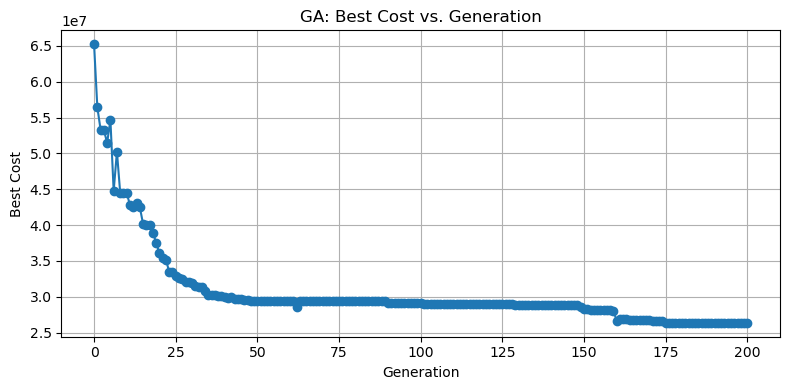

In [9]:
# --------------------------------------
# CREATING GA INDIVIDUAL + FITNESS
# --------------------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# Gene: which driver (0…num_drivers-1) handles this customer
toolbox.register("attr_driver", random.randrange, num_drivers)
# Individual: assignment for all customers
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_driver, n=C)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Four‐term weights (must sum to 1)
α_dh, α_df, α_cf, α_p = 0.25, 0.25, 0.25, 0.25

def evaluate(ind):
    """Evaluate one individual, return (cost,)"""
    # decode assignment
    assign = {d: [] for d in drivers}
    for i, drv in enumerate(ind):
        assign[drivers[drv]].append(customers[i])

    total_served = total_empty = 0.0
    ratios = []   # pr_j / dh_j
    ds_vals = []  # each dsi
    prio_sum = 0.0

    pen_wait = pen_cap = pen_shift = 0.0

    for d in drivers:
        route = assign[d]
        if not route:
            continue

        # imposing a consistent order
        route_sorted = sorted(route, key=lambda c: int(c[1:]))

        # build loop 0→...→0
        loop = ["0"] + route_sorted + ["0"]
        legs = [dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
        served_dist = sum(legs[1:-1])
        empty_dist  = legs[0] + legs[-1]
        total_served += served_dist
        total_empty  += empty_dist

        dh_j = empty_dist
        pr_j = served_dist
        ratios.append(pr_j/(dh_j+1e-6))

        # computing ds_i and priority term
        accum = 0.0
        for idx, ci in enumerate(route_sorted):
            prev = loop[idx]
            curr = loop[idx+1]
            leg = dist[prev,curr]
            accum += leg
            ds_vals.append(accum)
            prio_sum += leg * priority[ci] / max(1e-3, accum)

        # check wait‐time cap
        t_elapsed = 0.0
        for idx, ci in enumerate(route_sorted):
            prev, curr = loop[idx], loop[idx+1]
            tleg = time_dist[prev,curr]
            t_elapsed += tleg
            if t_elapsed > T_max:
                pen_wait += (t_elapsed - T_max)**2
            t_elapsed += service_tm

        # check shift length
        back_leg = time_dist[route_sorted[-1], "0"]
        total_time = t_elapsed + back_leg
        if total_time > shift_min:
            pen_shift += (total_time - shift_min)**2

        # check capacity
        load = sum(demand[c] for c in route_sorted)
        if load > capacity:
            pen_cap += (load - capacity)**2

    # assemble objective terms
    term1 = -(total_served + total_empty)
    term2 = -np.std(ratios) if ratios else 0.0
    term3 = -np.std(ds_vals) if ds_vals else 0.0
    term4 = -prio_sum

    base_cost = α_dh*term1 + α_df*term2 + α_cf*term3 + α_p*term4
    penalties = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift

    return (base_cost + penalties,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate",    tools.cxOnePoint)
toolbox.register("mutate",  tools.mutUniformInt,
                 low=0, up=num_drivers-1, indpb=0.1)
toolbox.register("select",  tools.selTournament, tournsize=3)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", np.min)

# --------------------------------------
#RUN GA
# --------------------------------------
pop = toolbox.population(n=200)
# evaluate init pop
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

hof     = tools.HallOfFame(1)
logbook = tools.Logbook()

start = time.time()
pop, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=0.7, mutpb=0.2,
    ngen=200,
    stats=stats,
    halloffame=hof,
    verbose=True
)
elapsed_ga = time.time() - start

gen_costs = logbook.select("min")

# --------------------------------------
# REPORT & PLOT
# --------------------------------------
best = hof[0]
initial, best_ga_cost = gen_costs[0], gen_costs[-1]

# decode best assignment
assignment = {d: [] for d in drivers}
for i, drv in enumerate(best):
    assignment[drivers[drv]].append(customers[i])

used_ga = [d for d in drivers if assignment[d]]

# 2) Build a new dict mapping “new” names to the old routes
renumbered_ga = {}
for new_idx, old_name in enumerate(used_ga, start=1):
    new_label = f"D{new_idx}"
    renumbered_ga[new_label] = assignment[old_name]

print(f"\nGA elapsed time: {elapsed_ga:.2f}s")
print(f"Initial best cost: {initial:.2f}")
print(f"  Final best cost: {best_ga_cost:.2f}")
print(f"Drivers used: {len(used_ga)}")
for d, custs in renumbered_ga.items():
    print(f"{d} → {custs}")

# convergence plot
plt.figure(figsize=(8,4))
plt.plot(gen_costs, marker='o', linestyle='-')
plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("GA: Best Cost vs. Generation")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADAPTIVE GENETIC ALGORITHM IMPLEMENTATION


GA elapsed time: 50.45s

Best GA Config → pop_size: 200, cxpb: 0.5, mutpb: 0.3
Best final cost: 25177120.63
Drivers used: 157
D1 → ['C55']
D2 → ['C5']
D3 → ['C96']
D4 → ['C65']
D5 → ['C114']
D6 → ['C4']
D7 → ['C118']
D8 → ['C144']
D9 → ['C63']
D10 → ['C24']
D11 → ['C143']
D12 → ['C39', 'C94']
D13 → ['C47']
D14 → ['C41']
D15 → ['C34']
D16 → ['C76']
D17 → ['C32']
D18 → ['C139']
D19 → ['C120']
D20 → ['C14', 'C115']
D21 → ['C137']
D22 → ['C40']
D23 → ['C182']
D24 → ['C171']
D25 → ['C126']
D26 → ['C89']
D27 → ['C9', 'C86']
D28 → ['C66']
D29 → ['C45', 'C57']
D30 → ['C101']
D31 → ['C56', 'C180']
D32 → ['C131', 'C186']
D33 → ['C155']
D34 → ['C128']
D35 → ['C71']
D36 → ['C75']
D37 → ['C169']
D38 → ['C15']
D39 → ['C129']
D40 → ['C127']
D41 → ['C172']
D42 → ['C111']
D43 → ['C6', 'C51']
D44 → ['C163']
D45 → ['C140']
D46 → ['C49']
D47 → ['C187']
D48 → ['C12', 'C149']
D49 → ['C92']
D50 → ['C43', 'C179']
D51 → ['C78']
D52 → ['C154']
D53 → ['C10']
D54 → ['C116']
D55 → ['C102']
D56 → ['C35']
D57 → ['C

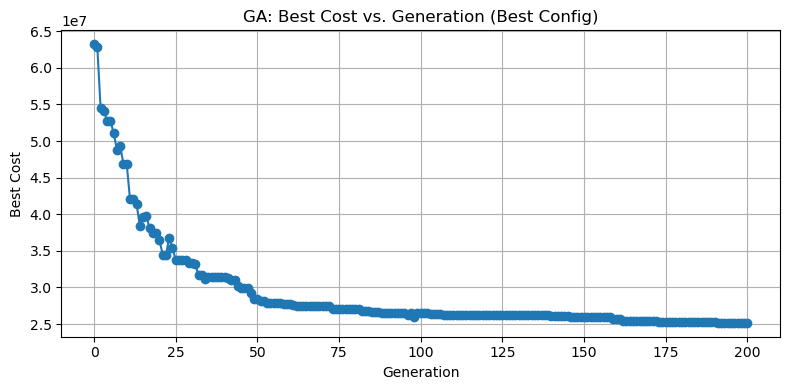

In [11]:
pop_sizes = [100, 200, 300]
cxpbs     = [0.5, 0.7, 0.9]
mutpbs    = [0.1, 0.2, 0.3]
gen       = 200

adaptive_ga_cost = float('inf')
best_config = None
best_solution = None
best_assignment = None
best_log = None

# --------------------------------------
# CREATE GA INDIVIDUAL + FITNESS
# --------------------------------------

for pop_size in pop_sizes:
    for cxpb in cxpbs:
        for mutpb in mutpbs:

            toolbox = base.Toolbox()
            toolbox.register("attr_driver", random.randrange, num_drivers)
            toolbox.register("individual", tools.initRepeat, creator.Individual,
                             toolbox.attr_driver, n=C)
            toolbox.register("population", tools.initRepeat, list, toolbox.individual)

            def evaluate(ind):
                assign = {d: [] for d in drivers}
                for i, drv in enumerate(ind):
                    assign[drivers[drv]].append(customers[i])

                total_served = total_empty = 0.0
                ratios = []
                ds_vals = []
                prio_sum = 0.0
                pen_wait = pen_cap = pen_shift = 0.0

                for d in drivers:
                    route = assign[d]
                    if not route:
                        continue

                    route_sorted = sorted(route, key=lambda c: int(c[1:]))
                    loop = ["0"] + route_sorted + ["0"]
                    legs = [dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
                    served_dist = sum(legs[1:-1])
                    empty_dist  = legs[0] + legs[-1]
                    total_served += served_dist
                    total_empty  += empty_dist

                    dh_j = empty_dist
                    pr_j = served_dist
                    ratios.append(pr_j/(dh_j+1e-6))

                    accum = 0.0
                    for idx, ci in enumerate(route_sorted):
                        prev, curr = loop[idx], loop[idx+1]
                        leg = dist[prev, curr]
                        accum += leg
                        ds_vals.append(accum)
                        prio_sum += leg * priority[ci] / max(1e-3, accum)

                    t_elapsed = 0.0
                    for idx, ci in enumerate(route_sorted):
                        prev, curr = loop[idx], loop[idx+1]
                        t_elapsed += time_dist[prev, curr]
                        if t_elapsed > T_max:
                            pen_wait += (t_elapsed - T_max)**2
                        t_elapsed += service_tm

                    back_leg = time_dist[route_sorted[-1], "0"]
                    if t_elapsed + back_leg > shift_min:
                        pen_shift += (t_elapsed + back_leg - shift_min)**2

                    load = sum(demand[c] for c in route_sorted)
                    if load > capacity:
                        pen_cap += (load - capacity)**2

                term1 = -(total_served + total_empty)
                term2 = -np.std(ratios) if ratios else 0.0
                term3 = -np.std(ds_vals) if ds_vals else 0.0
                term4 = -prio_sum

                base_cost = 0.25*term1 + 0.25*term2 + 0.25*term3 + 0.25*term4
                penalties = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift
                return (base_cost + penalties,)

            toolbox.register("evaluate", evaluate)
            toolbox.register("mate",    tools.cxOnePoint)
            toolbox.register("mutate",  tools.mutUniformInt,
                             low=0, up=num_drivers-1, indpb=0.1)
            toolbox.register("select",  tools.selTournament, tournsize=3)

            stats = tools.Statistics(lambda ind: ind.fitness.values[0])
            stats.register("min", np.min)
            hof = tools.HallOfFame(1)
            logbook = tools.Logbook()

            pop = toolbox.population(n=pop_size)
            for ind in pop:
                ind.fitness.values = toolbox.evaluate(ind)

            start = time.time()
            pop, logbook = algorithms.eaSimple(
                pop, toolbox,
                cxpb=cxpb, mutpb=mutpb,
                ngen=gen, stats=stats,
                halloffame=hof, verbose=False
            )
            

            final_cost = logbook.select("min")[-1]
            if final_cost < adaptive_ga_cost:
                adaptive_ga_cost = final_cost
                best_config = (pop_size, cxpb, mutpb)
                best_solution = hof[0]
                best_log = logbook
                best_assignment = {d: [] for d in drivers}
                for i, drv in enumerate(best_solution):
                    best_assignment[drivers[drv]].append(customers[i])
            
            elapsed_best_ga = time.time() - start

# --------------------------------------
# FINAL REPORTING FOR BEST CONFIG
# --------------------------------------
used_adaptive_ga = [d for d in drivers if best_assignment[d]]
renumbered_adaptive_ga = {f"D{new_idx}": best_assignment[d] for new_idx, d in enumerate(used_adaptive_ga, start=1)}

print(f"\nGA elapsed time: {elapsed_best_ga:.2f}s")
print(f"\nBest GA Config → pop_size: {best_config[0]}, cxpb: {best_config[1]}, mutpb: {best_config[2]}")
print(f"Best final cost: {adaptive_ga_cost:.2f}")
print(f"Drivers used: {len(renumbered_adaptive_ga)}")
for d, custs in renumbered_adaptive_ga.items():
    print(f"{d} → {custs}")

plt.figure(figsize=(8,4))
plt.plot(best_log.select("min"), marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("GA: Best Cost vs. Generation (Best Config)")
plt.grid(True)
plt.tight_layout()
plt.show()

### FIXED VS ADAPTIVE GA CONFIGURATION COMPARISON 

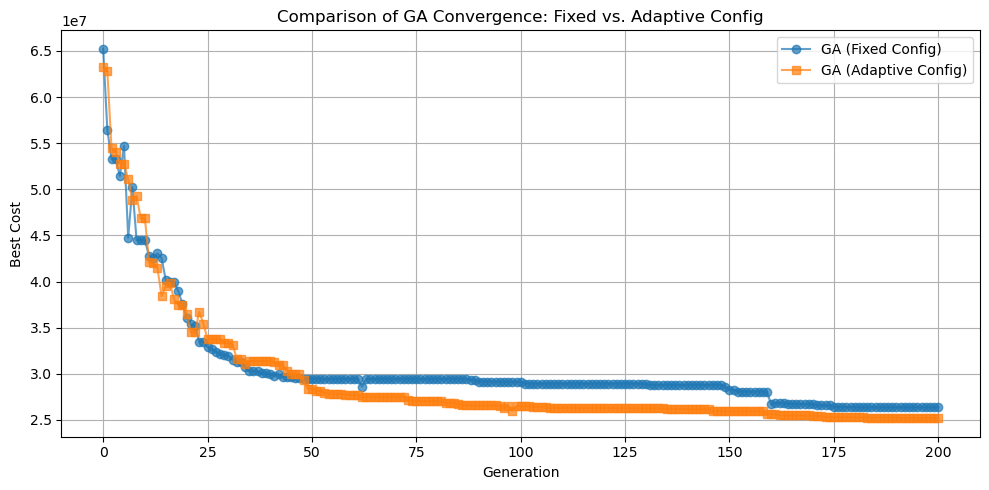

In [13]:
plt.figure(figsize=(10, 5))

# Plot original GA curve
plt.plot(gen_costs, marker='o', linestyle='-', label='GA (Fixed Config)', alpha=0.7)

# Plot best adaptive GA curve
plt.plot(best_log.select("min"), marker='s', linestyle='-', label='GA (Adaptive Config)', alpha=0.7)

plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("Comparison of GA Convergence: Fixed vs. Adaptive Config")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PARTICLE SWARM OPTIMIZATION ALGORITHM IMPLEMENTATION

2025-05-15 04:36:39,878 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=5.88e+7
2025-05-15 04:36:49,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 58787700.90592985, best pos: [ 46.65598713  88.49597521 105.58889548 146.54534602  87.85403574
  33.37633818  37.58541577 100.87151311  51.214992   114.34039407
  35.49063194 157.64717396 128.30008603 118.46767158 142.45801412
  69.4755242   94.92227824   7.90284587 148.6653182   75.16827575
   6.34595772  37.07381696 170.34920791  28.67544857  64.71937329
 149.44423974 116.41224609 122.07863942 131.87560326 164.49170173
  49.42585148  72.62009281 142.64372471  90.38023353 104.41527966
  60.75077931  83.25120558 186.95028505  48.15907115  50.204651
 184.25151483 149.27186655  85.44382819 119.18841866 182.9616878
 123.33957001  98.49235354  41.32554504 121.67076983  57.55635582
 153.39249378  73.16


PSO elapsed time: 10.02 s
Final PSO cost:    58787700.9059
Drivers used:      129
D1 → ['C120']
D2 → ['C151']
D3 → ['C153']
D4 → ['C21']
D5 → ['C157']
D6 → ['C18']
D7 → ['C110']
D8 → ['C57', 'C103', 'C183']
D9 → ['C68']
D10 → ['C149', 'C159']
D11 → ['C92']
D12 → ['C107']
D13 → ['C123', 'C147']
D14 → ['C55']
D15 → ['C24', 'C102', 'C179']
D16 → ['C152']
D17 → ['C178', 'C182']
D18 → ['C112']
D19 → ['C6']
D20 → ['C11']
D21 → ['C109', 'C187']
D22 → ['C22', 'C69']
D23 → ['C7', 'C67']
D24 → ['C48']
D25 → ['C72']
D26 → ['C118']
D27 → ['C1']
D28 → ['C39', 'C54']
D29 → ['C31', 'C74', 'C161']
D30 → ['C40', 'C167']
D31 → ['C9']
D32 → ['C86', 'C132']
D33 → ['C56']
D34 → ['C115', 'C165']
D35 → ['C50']
D36 → ['C127']
D37 → ['C78', 'C91']
D38 → ['C36']
D39 → ['C117']
D40 → ['C170']
D41 → ['C25', 'C84']
D42 → ['C83', 'C162', 'C176']
D43 → ['C145']
D44 → ['C16']
D45 → ['C126', 'C143']
D46 → ['C139', 'C163']
D47 → ['C177']
D48 → ['C32', 'C52']
D49 → ['C93', 'C150']
D50 → ['C20', 'C192']
D51 → ['C59', 'C

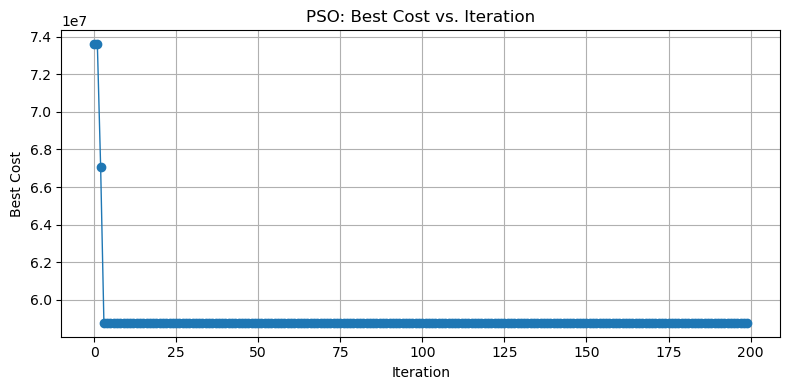

In [15]:

# --------------------------------------
# PSO OBJECTIVE (with penalties)
# --------------------------------------
# weights on the four terms (must sum to 1)
α_dh, α_df, α_cf, α_p = 0.25, 0.25, 0.25, 0.25

def objective(x):
    """
    x: (n_particles, C) 
    each row is a vector of continuous values in [0, num_drivers).
    We round to int to assign each customer to a driver.
    """
    n_particles = x.shape[0]
    costs = np.zeros(n_particles)
    for p in range(n_particles):
        # decode assignment
        assign_idx = np.clip(np.round(x[p]), 0, num_drivers-1).astype(int)
        assigned = {d: [] for d in drivers}
        for i, drv in enumerate(assign_idx):
            assigned[drivers[drv]].append(customers[i])

        # Term 1: Deadheading = -(served + empty)
        total_served = 0.0
        total_empty  = 0.0

        # Term 2: driver fairness = stddev of pr_j / dh_j
        ratios = []

        # Term 3: customer fairness = stddev of ds_i
        ds_vals = []

        # Term 4: priority reward
        prio_sum = 0.0

        # penalty accumulators
        pen_wait   = 0.0
        pen_cap    = 0.0
        pen_shift  = 0.0

        for d in drivers:
            route = assigned[d]
            if len(route)==0:
                # if driver unused, skip fairness
                continue

            # impose an order by customer index (1..C)
            route_sorted = sorted(route, key=lambda c: int(c[1:]))

            # build full loop 0→c1→...→cn→0
            loop = ["0"] + route_sorted + ["0"]
            legs = [dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
            served_dist = sum(legs[1:-1])
            empty_dist  = legs[0] + legs[-1]
            total_served += served_dist
            total_empty  += empty_dist

            # pr_j, dh_j
            dh_j = empty_dist
            pr_j = served_dist
            ratios.append(pr_j/(dh_j+1e-6))

            # ds_i and priority contributions
            accum = 0.0
            for i, ci in enumerate(route_sorted):
                prev = loop[i]
                curr = loop[i+1]
                leg = dist[prev,curr]
                accum += leg
                ds_vals.append(accum)
                prio_sum += leg * priority[ci] / max(1e-3, accum)

            # compute wait times for each served customer
            time_elapsed = 0.0
            # time from depot to first + service + ...
            for i, ci in enumerate(route_sorted):
                prev = loop[i]
                curr = loop[i+1]
                tleg = time_dist[prev, curr]
                time_elapsed += tleg
                # check wait cap
                if time_elapsed > T_max:
                    pen_wait += (time_elapsed - T_max)**2
                time_elapsed += service_tm

            # check shift length
            total_time = time_elapsed + time_dist[route_sorted[-1], "0"]
            if total_time > shift_min:
                pen_shift += (total_time - shift_min)**2

            # check capacity
            load = sum(demand[c] for c in route_sorted)
            if load > capacity:
                pen_cap += (load - capacity)**2

        # assemble terms
        term1 = -(total_served + total_empty)
        term2 = -np.std(ratios) if ratios else 0.0
        term3 = -np.std(ds_vals) if ds_vals else 0.0
        term4 = -prio_sum

        base_cost = α_dh*term1 + α_df*term2 + α_cf*term3 + α_p*term4

        # aggregate with penalties (choose large penalty factors)
        penalties = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift

        costs[p] = base_cost + penalties

    return costs

# --------------------------------------
# RUN PSO
# --------------------------------------
# bounds: each x_ij in [0, num_drivers-1]
lower = np.zeros(C)                  # 1-D array of length C
upper = np.ones(C) * (num_drivers-1) # 1-D array of length C
bounds = (lower, upper)

options = {
    "c1": 1.5,    # cognitive
    "c2": 1.5,    # social
    "w" : 0.7,    # inertia
}

# Create the optimizer with correct bounds shape
optimizer = ps.single.GlobalBestPSO(
    n_particles=50,
    dimensions=C,
    options=options,
    bounds=bounds    # now correctly two 1-D arrays of shape (C,)
)

# Run optimization as before
start = time.time()
best_pso_cost, best_pos = optimizer.optimize(objective, iters=200)
elapsed_pso = time.time() - start

# decode best assignment
best_idx = np.clip(np.round(best_pos), 0, num_drivers-1).astype(int)
assignment = {d: [] for d in drivers}
for i, drv in enumerate(best_idx):
    assignment[drivers[drv]].append(customers[i])
# 1) Collect only the drivers with non-empty routes, in original order
used_pso = [d for d in drivers if assignment[d]]

# 2) Build a new dict mapping “new” names to the old routes
renumbered_pso = {}
for new_idx, old_name in enumerate(used_pso, start=1):
    new_label = f"D{new_idx}"
    renumbered_pso[new_label] = assignment[old_name]

# --------------------------------------
# REPORT & PLOT
# --------------------------------------
print(f"\nPSO elapsed time: {elapsed_pso:.2f} s")
print(f"Final PSO cost:    {best_pso_cost:.4f}")
print(f"Drivers used:      {len(renumbered_pso)}")
# 3) (Optional) print out
for d, custs in renumbered_pso.items():
    print(f"{d} → {custs}")

# plot convergence
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("PSO: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADAPTIVE PARTICLE SWARM OPTIMIZATION ALGORITHM IMPLEMENTATION

Trying config: c1=1.0, c2=1.0, w=0.5
Trying config: c1=1.0, c2=1.0, w=0.7
Trying config: c1=1.0, c2=1.0, w=0.9
Trying config: c1=1.0, c2=1.5, w=0.5
Trying config: c1=1.0, c2=1.5, w=0.7
Trying config: c1=1.0, c2=1.5, w=0.9
Trying config: c1=1.0, c2=2.0, w=0.5
Trying config: c1=1.0, c2=2.0, w=0.7
Trying config: c1=1.0, c2=2.0, w=0.9
Trying config: c1=1.5, c2=1.0, w=0.5
Trying config: c1=1.5, c2=1.0, w=0.7
Trying config: c1=1.5, c2=1.0, w=0.9
Trying config: c1=1.5, c2=1.5, w=0.5
Trying config: c1=1.5, c2=1.5, w=0.7
Trying config: c1=1.5, c2=1.5, w=0.9
Trying config: c1=1.5, c2=2.0, w=0.5
Trying config: c1=1.5, c2=2.0, w=0.7
Trying config: c1=1.5, c2=2.0, w=0.9
Trying config: c1=2.0, c2=1.0, w=0.5
Trying config: c1=2.0, c2=1.0, w=0.7
Trying config: c1=2.0, c2=1.0, w=0.9
Trying config: c1=2.0, c2=1.5, w=0.5
Trying config: c1=2.0, c2=1.5, w=0.7
Trying config: c1=2.0, c2=1.5, w=0.9
Trying config: c1=2.0, c2=2.0, w=0.5
Trying config: c1=2.0, c2=2.0, w=0.7
Trying config: c1=2.0, c2=2.0, w=0.9



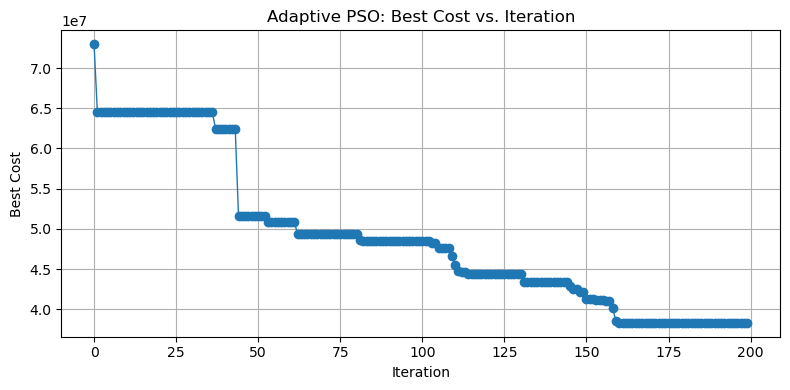

In [31]:
# --------------------------------------
# PARAMETER RANGES TO TUNE
# --------------------------------------
c1_values = [1.0, 1.5, 2.0]
c2_values = [1.0, 1.5, 2.0]
w_values  = [0.5, 0.7, 0.9]

best_config = None
adaptive_pso_cost = float('inf')
best_optimizer = None
best_assignment = None
best_position = None

# --------------------------------------
# DEFINE OBJECTIVE (no change needed)
# --------------------------------------
def objective(x):
    n_particles = x.shape[0]
    costs = np.zeros(n_particles)
    for p in range(n_particles):
        assign_idx = np.clip(np.round(x[p]), 0, num_drivers-1).astype(int)
        assigned = {d: [] for d in drivers}
        for i, drv in enumerate(assign_idx):
            assigned[drivers[drv]].append(customers[i])

        total_served = total_empty = 0.0
        ratios = []
        ds_vals = []
        prio_sum = 0.0
        pen_wait = pen_cap = pen_shift = 0.0

        for d in drivers:
            route = assigned[d]
            if not route:
                continue

            route_sorted = sorted(route, key=lambda c: int(c[1:]))
            loop = ["0"] + route_sorted + ["0"]
            legs = [dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
            served_dist = sum(legs[1:-1])
            empty_dist  = legs[0] + legs[-1]
            total_served += served_dist
            total_empty  += empty_dist
            ratios.append(served_dist / (empty_dist+1e-6))

            accum = 0.0
            for i, ci in enumerate(route_sorted):
                prev, curr = loop[i], loop[i+1]
                leg = dist[prev, curr]
                accum += leg
                ds_vals.append(accum)
                prio_sum += leg * priority[ci] / max(1e-3, accum)

            t_elapsed = 0.0
            for i, ci in enumerate(route_sorted):
                prev, curr = loop[i], loop[i+1]
                tleg = time_dist[prev, curr]
                t_elapsed += tleg
                if t_elapsed > T_max:
                    pen_wait += (t_elapsed - T_max)**2
                t_elapsed += service_tm

            total_time = t_elapsed + time_dist[route_sorted[-1], "0"]
            if total_time > shift_min:
                pen_shift += (total_time - shift_min)**2

            load = sum(demand[c] for c in route_sorted)
            if load > capacity:
                pen_cap += (load - capacity)**2

        term1 = -(total_served + total_empty)
        term2 = -np.std(ratios) if ratios else 0.0
        term3 = -np.std(ds_vals) if ds_vals else 0.0
        term4 = -prio_sum

        base_cost = 0.25*term1 + 0.25*term2 + 0.25*term3 + 0.25*term4
        penalties = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift
        costs[p] = base_cost + penalties

    return costs

# --------------------------------------
# ADAPTIVE GRID SEARCH
# --------------------------------------
for c1 in c1_values:
    for c2 in c2_values:
        for w in w_values:
            print(f"Trying config: c1={c1}, c2={c2}, w={w}")
            options = {"c1": c1, "c2": c2, "w": w}
            bounds = (np.zeros(C), np.ones(C)*(num_drivers-1))

            optimizer = GlobalBestPSO(
                n_particles=50, dimensions=C,
                options=options, bounds=bounds
            )

            start = time.time()
            cost, pos = optimizer.optimize(objective, iters=200, verbose=False)
            

            if cost < adaptive_pso_cost:
                adaptive_pso_cost = cost
                best_position = pos
                best_optimizer = optimizer
                best_config = (c1, c2, w)
                # decode assignment
                idx = np.clip(np.round(pos), 0, num_drivers-1).astype(int)
                best_assignment = {d: [] for d in drivers}
                for i, drv in enumerate(idx):
                    best_assignment[drivers[drv]].append(customers[i])
                    
                elapsed_best_pso = time.time() - start

# --------------------------------------
# REPORT & PLOT
# --------------------------------------
used_adaptive_pso = [d for d in drivers if best_assignment[d]]
renumbered_adaptive_pso = {f"D{new_idx}": best_assignment[d] for new_idx, d in enumerate(used_adaptive_pso, start=1)}

print(f"\nPSO elapsed time: {elapsed_best_pso:.2f}s")
print(f"\nBest PSO Config → c1: {best_config[0]}, c2: {best_config[1]}, w: {best_config[2]}")
print(f"Final best PSO cost: {adaptive_pso_cost:.2f}")
print(f"Drivers used: {len(renumbered_adaptive_pso)}")
for d, custs in renumbered_adaptive_pso.items():
    print(f"{d} → {custs}")

# PLOT best convergence
plt.figure(figsize=(8,4))
plt.plot(best_optimizer.cost_history, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("Adaptive PSO: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### FIXED VS ADAPTIVE PSO CONFIGURATION COMPARISON

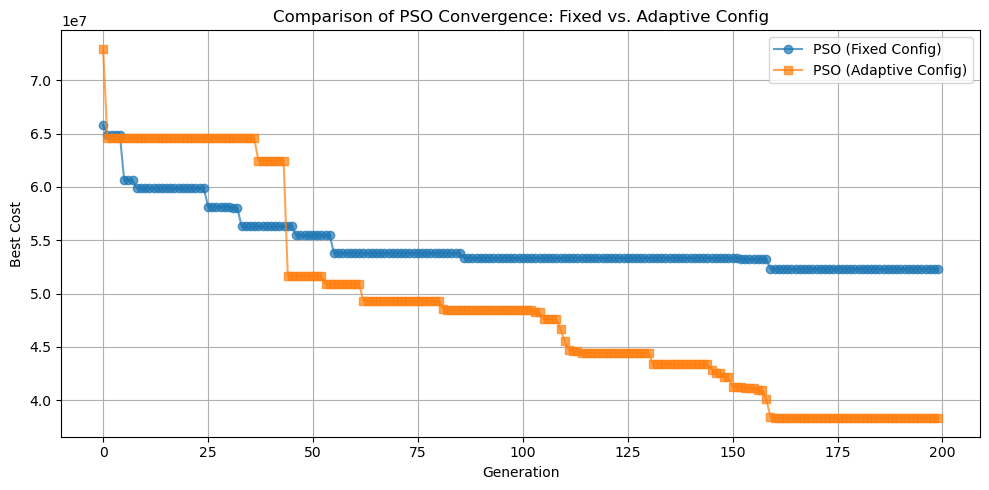

In [33]:
plt.figure(figsize=(10, 5))

# Plot original PSO curve
plt.plot(optimizer.cost_history, marker='o', linestyle='-', label='PSO (Fixed Config)', alpha=0.7)

# Plot best adaptive PSO curve
plt.plot(best_optimizer.cost_history, marker='s', linestyle='-', label='PSO (Adaptive Config)', alpha=0.7)

plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("Comparison of PSO Convergence: Fixed vs. Adaptive Config")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### AQUILA OPTIMIZATION ALGORITHM IMPLEMENTATION


AO elapsed time: 14.96s
Final AO cost:    52717800.6633
Drivers used:     129
D1 → ['C120']
D2 → ['C151']
D3 → ['C153']
D4 → ['C21']
D5 → ['C157']
D6 → ['C18']
D7 → ['C110']
D8 → ['C57', 'C103', 'C183']
D9 → ['C68']
D10 → ['C149', 'C159']
D11 → ['C92']
D12 → ['C107']
D13 → ['C123', 'C147']
D14 → ['C55']
D15 → ['C24', 'C102', 'C179']
D16 → ['C152']
D17 → ['C178', 'C182']
D18 → ['C112']
D19 → ['C6']
D20 → ['C11']
D21 → ['C109', 'C187']
D22 → ['C22', 'C69']
D23 → ['C7', 'C67']
D24 → ['C48']
D25 → ['C72']
D26 → ['C118']
D27 → ['C1']
D28 → ['C39', 'C54']
D29 → ['C31', 'C74', 'C161']
D30 → ['C40', 'C167']
D31 → ['C9']
D32 → ['C86', 'C132']
D33 → ['C56']
D34 → ['C115', 'C165']
D35 → ['C50']
D36 → ['C127']
D37 → ['C78', 'C91']
D38 → ['C36']
D39 → ['C117']
D40 → ['C170']
D41 → ['C25', 'C84']
D42 → ['C83', 'C162', 'C176']
D43 → ['C145']
D44 → ['C16']
D45 → ['C126', 'C143']
D46 → ['C139', 'C163']
D47 → ['C177']
D48 → ['C32', 'C52']
D49 → ['C93', 'C150']
D50 → ['C20', 'C192']
D51 → ['C59', 'C166'

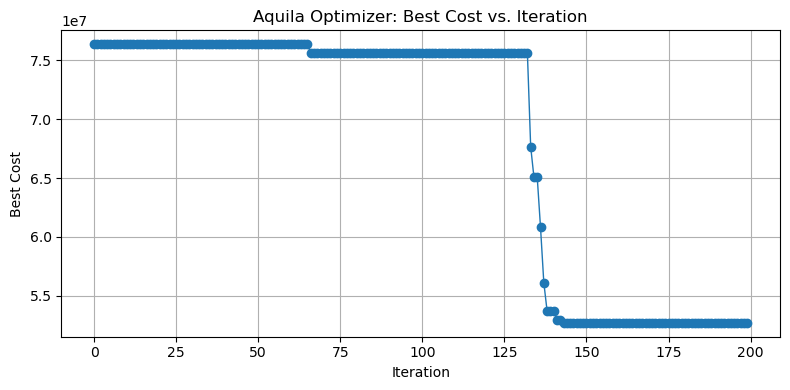

In [35]:


# Precompute hub→cust dist for quick empty‐legs approximations
hub_dist = {c: dist["0",c] for c in customers}

# --------------------------------------
# COST FUNCTION (with all 4 terms + penalties)
# --------------------------------------
α_dh, α_df, α_cf, α_p = 0.25,0.25,0.25,0.25

def cost_of_assignment(assign_idx):
    """assign_idx: length‐C array of ints in [0,num_drivers)"""
    # build per‐driver routes
    assigned = {d:[] for d in drivers}
    for i,drv in enumerate(assign_idx):
        assigned[drivers[drv]].append(customers[i])

    total_served = total_empty = 0.0
    ratios = []     # Pr_j / Dh_j
    ds_vals = []    # each customer’s ds_i
    prio_sum = 0.0

    pen_wait = pen_cap = pen_shift = 0.0

    for d in drivers:
        route = assigned[d]
        if not route:
            continue

        # sort the route so solution is reproducible
        route_sorted = sorted(route, key=lambda c:int(c[1:]))

        # build delivery loop [0→c1→...→cn→0]
        loop = ["0"]+route_sorted+["0"]
        legs = [dist[loop[i],loop[i+1]] for i in range(len(loop)-1)]
        served = sum(legs[1:-1])
        empty  = legs[0]+legs[-1]
        total_served += served
        total_empty  += empty

        Dh_j = empty
        Pr_j = served
        ratios.append(Pr_j/(Dh_j+1e-6))

        # compute ds_i & priority reward
        accum = 0.0
        for idx,ci in enumerate(route_sorted):
            prev,cur = loop[idx], loop[idx+1]
            dleg = dist[prev,cur]
            accum += dleg
            ds_vals.append(accum)
            prio_sum += dleg * priority[ci] / max(1e-3,accum)

        # WAIT‐TIME penalty
        t_elapsed = 0.0
        for idx,ci in enumerate(route_sorted):
            prev,cur = loop[idx], loop[idx+1]
            t_elapsed += time_dist[prev,cur]
            if t_elapsed > T_max:
                pen_wait += (t_elapsed-T_max)**2
            t_elapsed += service_tm

        # SHIFT‐LENGTH penalty
        return_leg = time_dist[route_sorted[-1],"0"]
        if t_elapsed+return_leg > shift_min:
            pen_shift += (t_elapsed+return_leg-shift_min)**2

        # CAPACITY penalty
        load = sum(demand[c] for c in route_sorted)
        if load > capacity:
            pen_cap += (load-capacity)**2

    # assemble the four objective terms
    term1 = -(total_served+total_empty)   # deadheading
    term2 = -np.std(ratios) if ratios else 0.0
    term3 = -np.std(ds_vals) if ds_vals else 0.0
    term4 = -prio_sum

    base = α_dh*term1 + α_df*term2 + α_cf*term3 + α_p*term4
    penalty = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift
    return base + penalty

# --------------------------------------
# AQUILA OPTIMIZER IMPLEMENTATION
# --------------------------------------
def aquila_optimizer(cost_fn, n_dim, pop_size=50, max_iter=100):
    """
    Implements the four‐stage Aquila Optimizer.
    Returns: best_pos (int array), best_cost, history of best_cost
    """
    # initialize population uniformly on [0,num_drivers)
    X = np.random.uniform(0, num_drivers, size=(pop_size,n_dim))
    best_idx = None
    best_ao_cost = 1e18
    history = []

    for t in range(1, max_iter+1):
        T = max_iter
        X_mean = X.mean(axis=0)
        for i in range(pop_size):
            r1, r2, r3, r4 = np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()
            if t <= T/3:
                # Exploration I (high soar)
                X[i] = best_idx if best_idx is not None else X[i] \
                       + r1 * (X_mean/(X[i]+1e-6)) * (1 - t/T)
            elif t <= 2*T/3:
                # Exploration II (contour flight)
                X[i] = X[i] + r2*(best_idx - r3*X_mean)
            elif t <= 11*T/12:
                # Exploitation I (surprise pounce)
                X[i] = best_idx + r4*(best_idx - X[i])
            else:
                # Exploitation II (walk and grab)
                X[i] = best_idx + r1*(best_idx - X_mean)
            # boundary control
            X[i] = np.clip(X[i], 0, num_drivers-1)

        # evaluate
        costs = np.array([ cost_fn(np.round(x).astype(int)) for x in X ])
        idx = costs.argmin()
        if costs[idx] < best_ao_cost:
            best_ao_cost = float(costs[idx])
            best_idx  = X[idx].copy()
        history.append(best_ao_cost)

    return np.round(best_idx).astype(int), best_ao_cost, history

# --------------------------------------
# 5) RUN & REPORT
# --------------------------------------
start = time.time()
best_sol, best_ao_cost, hist = aquila_optimizer(cost_of_assignment, C,
                                          pop_size=100, max_iter=200)
elapsed_ao = time.time() - start

# decode best assignment
assign = {d:[] for d in drivers}
for i,drv in enumerate(best_sol):
    assign[drivers[drv]].append(customers[i])
used_ao = [d for d in drivers if assignment[d]]

# 2) Build a new dict mapping “new” names to the old routes
renumbered_ao = {}
for new_idx, old_name in enumerate(used_ao, start=1):
    new_label = f"D{new_idx}"
    renumbered_ao[new_label] = assignment[old_name]



print(f"\nAO elapsed time: {elapsed_ao:.2f}s")
print(f"Final AO cost:    {best_ao_cost:.4f}")
print(f"Drivers used:     {len(renumbered_ao)}")
# 3) (Optional) print out
for d, custs in renumbered_ao.items():
    print(f"{d} → {custs}")

# --------------------------------------
# 6) PLOT CONVERGENCE
# --------------------------------------
plt.figure(figsize=(8,4))
plt.plot(hist, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("Aquila Optimizer: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADAPTIVE AQUILA OPTIMIZATION ALGORITHM IMPLEMENTATION


AO elapsed time: 136.01s

AO Best Config → pop_size: 150, weights: (0.4, 0.2, 0.2, 0.2)
Final AO cost: 43318078.2273
Drivers used:  132
D1 → ['C32', 'C63', 'C84', 'C87']
D2 → ['C103', 'C117']
D3 → ['C37', 'C57']
D4 → ['C31']
D5 → ['C51']
D6 → ['C174']
D7 → ['C127']
D8 → ['C145']
D9 → ['C122', 'C175']
D10 → ['C131']
D11 → ['C29', 'C161']
D12 → ['C61', 'C120']
D13 → ['C99', 'C134']
D14 → ['C96', 'C119', 'C169']
D15 → ['C47', 'C193']
D16 → ['C62', 'C108']
D17 → ['C70', 'C185']
D18 → ['C85']
D19 → ['C86']
D20 → ['C110']
D21 → ['C112', 'C152']
D22 → ['C76']
D23 → ['C27', 'C80']
D24 → ['C81']
D25 → ['C130', 'C136']
D26 → ['C82']
D27 → ['C30']
D28 → ['C83']
D29 → ['C3']
D30 → ['C69']
D31 → ['C9', 'C146']
D32 → ['C72']
D33 → ['C94']
D34 → ['C15', 'C98']
D35 → ['C97']
D36 → ['C53', 'C170']
D37 → ['C56', 'C93']
D38 → ['C100', 'C177']
D39 → ['C11', 'C50']
D40 → ['C187']
D41 → ['C179']
D42 → ['C77', 'C102']
D43 → ['C21', 'C183']
D44 → ['C140', 'C163']
D45 → ['C90', 'C160']
D46 → ['C164']
D47 → ['

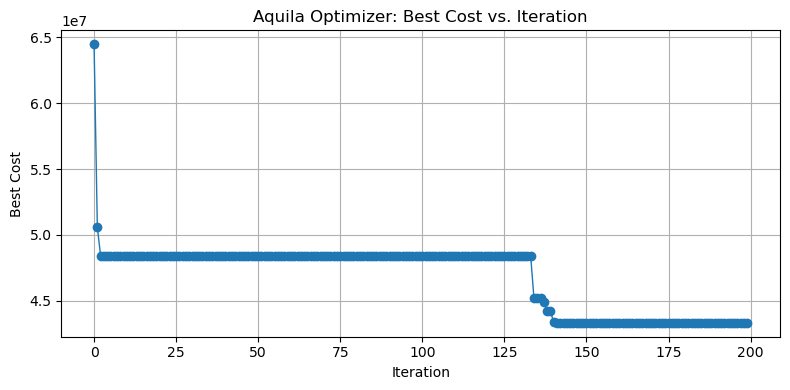

In [37]:
# --------------------------------------
# ADAPTIVE AQUILA OPTIMIZER
# --------------------------------------

# Precompute hub→cust dist for quick empty‐legs approximations
hub_dist = {c: dist["0", c] for c in customers}

# --------------------------------------
# PARAMETER RANGES (YOU CAN EDIT THESE)
# --------------------------------------
pop_sizes = [50, 100, 150]  # Try different population sizes
alpha_sets = [               # α_dh, α_df, α_cf, α_p sets (must sum to 1)
    (0.25, 0.25, 0.25, 0.25),
    (0.4, 0.2, 0.2, 0.2),
    (0.2, 0.2, 0.2, 0.4)
]

# --------------------------------------
# COST FUNCTION
# --------------------------------------
def cost_of_assignment(assign_idx, weights):
    α_dh, α_df, α_cf, α_p = weights
    assigned = {d: [] for d in drivers}
    for i, drv in enumerate(assign_idx):
        assigned[drivers[drv]].append(customers[i])

    total_served = total_empty = 0.0
    ratios = []
    ds_vals = []
    prio_sum = 0.0
    pen_wait = pen_cap = pen_shift = 0.0

    for d in drivers:
        route = assigned[d]
        if not route:
            continue

        route_sorted = sorted(route, key=lambda c: int(c[1:]))
        loop = ["0"] + route_sorted + ["0"]
        legs = [dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
        served = sum(legs[1:-1])
        empty = legs[0] + legs[-1]
        total_served += served
        total_empty += empty

        Dh_j, Pr_j = empty, served
        ratios.append(Pr_j / (Dh_j + 1e-6))

        accum = 0.0
        for idx, ci in enumerate(route_sorted):
            prev, cur = loop[idx], loop[idx+1]
            dleg = dist[prev, cur]
            accum += dleg
            ds_vals.append(accum)
            prio_sum += dleg * priority[ci] / max(1e-3, accum)

        t_elapsed = 0.0
        for idx, ci in enumerate(route_sorted):
            prev, cur = loop[idx], loop[idx+1]
            t_elapsed += time_dist[prev, cur]
            if t_elapsed > T_max:
                pen_wait += (t_elapsed - T_max)**2
            t_elapsed += service_tm

        return_leg = time_dist[route_sorted[-1], "0"]
        if t_elapsed + return_leg > shift_min:
            pen_shift += (t_elapsed + return_leg - shift_min)**2

        load = sum(demand[c] for c in route_sorted)
        if load > capacity:
            pen_cap += (load - capacity)**2

    term1 = -(total_served + total_empty)
    term2 = -np.std(ratios) if ratios else 0.0
    term3 = -np.std(ds_vals) if ds_vals else 0.0
    term4 = -prio_sum

    base = α_dh*term1 + α_df*term2 + α_cf*term3 + α_p*term4
    penalty = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift
    return base + penalty

# --------------------------------------
# AQUILA OPTIMIZER FUNCTION
# --------------------------------------
def aquila_optimizer(cost_fn, n_dim, pop_size=50, max_iter=200):
    X = np.random.uniform(0, num_drivers, size=(pop_size, n_dim))
    best_idx = None
    best_cost = 1e18
    history = []

    for t in range(1, max_iter+1):
        T = max_iter
        X_mean = X.mean(axis=0)
        for i in range(pop_size):
            r1, r2, r3, r4 = np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()
            if t <= T/3:
                X[i] = (best_idx if best_idx is not None else X[i]) + r1 * (X_mean / (X[i] + 1e-6)) * (1 - t/T)
            elif t <= 2*T/3:
                X[i] = X[i] + r2 * (best_idx - r3 * X_mean)
            elif t <= 11*T/12:
                X[i] = best_idx + r4 * (best_idx - X[i])
            else:
                X[i] = best_idx + r1 * (best_idx - X_mean)
            X[i] = np.clip(X[i], 0, num_drivers-1)

        costs = np.array([cost_fn(np.round(x).astype(int)) for x in X])
        idx = costs.argmin()
        if costs[idx] < best_cost:
            best_cost = float(costs[idx])
            best_idx = X[idx].copy()
        history.append(best_cost)

    return np.round(best_idx).astype(int), best_cost, history

# --------------------------------------
# ADAPTIVE SEARCH
# --------------------------------------
start = time.time()
adaptive_ao_cost = float("inf")
best_sol = None
best_hist = []
best_config = None

for pop_size in pop_sizes:
    for alpha_weights in alpha_sets:
        cost_fn = lambda idx: cost_of_assignment(idx, alpha_weights)
        sol, cost, hist = aquila_optimizer(cost_fn, C, pop_size=pop_size, max_iter=200)
        if cost < adaptive_ao_cost:
            adaptive_ao_cost = cost
            best_sol = sol
            best_hist = hist
            best_config = (pop_size, alpha_weights)

elapsed_best_ao = time.time() - start

# --------------------------------------
# DECODE BEST SOLUTION
# --------------------------------------
assignment = {d: [] for d in drivers}
for i, drv in enumerate(best_sol):
    assignment[drivers[drv]].append(customers[i])
used_adaptive_ao = [d for d in drivers if assignment[d]]
renumbered_adaptive_ao = {f"D{new_idx}": assignment[d] for new_idx, d in enumerate(used_adaptive_ao, start=1)}

# --------------------------------------
# REPORT
# --------------------------------------
print(f"\nAO elapsed time: {elapsed_best_ao:.2f}s")
print(f"\nAO Best Config → pop_size: {best_config[0]}, weights: {best_config[1]}")
print(f"Final AO cost: {adaptive_ao_cost:.4f}")
print(f"Drivers used:  {len(renumbered_adaptive_ao)}")
for d, custs in renumbered_adaptive_ao.items():
    print(f"{d} → {custs}")

# --------------------------------------
# CONVERGENCE PLOT
# --------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(best_hist, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("Aquila Optimizer: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### FIXED VS ADAPTIVE AO CONFIGURATION COMPARISON 

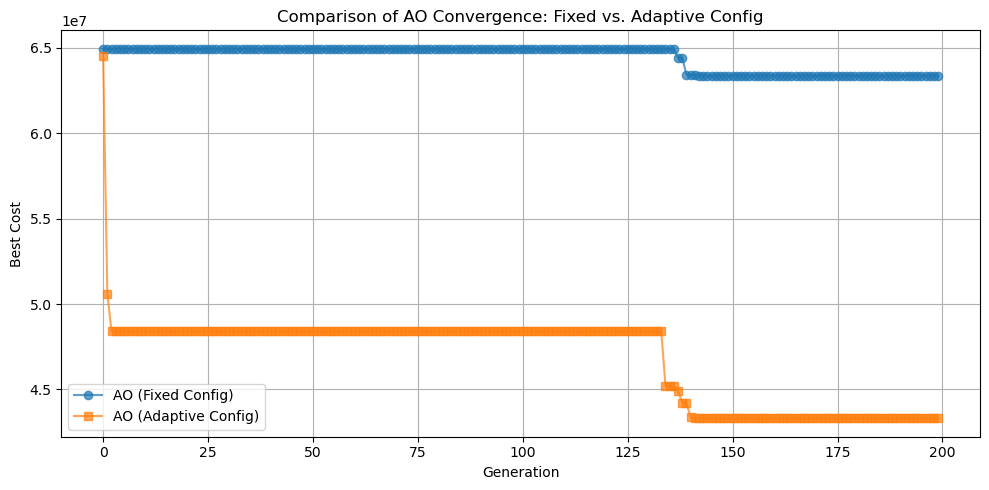

In [39]:
plt.figure(figsize=(10, 5))

# Plot original AO curve
plt.plot(hist, marker='o', linestyle='-', label='AO (Fixed Config)', alpha=0.7)

# Plot best adaptive AO curve
plt.plot(best_hist, marker='s', linestyle='-', label='AO (Adaptive Config)', alpha=0.7)

plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("Comparison of AO Convergence: Fixed vs. Adaptive Config")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GREY WOLF OPTIMIZATION ALGORITHM IMPLEMENTATION


GWO elapsed time: 14.46s
Final GWO cost:    47425833.2457
Drivers used: 129
Assignment:
  D1 → ['C16']
  D2 → ['C92']
  D3 → ['C80']
  D4 → ['C38', 'C189']
  D5 → ['C18']
  D6 → ['C183']
  D7 → ['C67']
  D8 → ['C24']
  D9 → ['C4', 'C166']
  D10 → ['C2', 'C31']
  D11 → ['C106', 'C173']
  D12 → ['C23']
  D13 → ['C71']
  D14 → ['C13']
  D15 → ['C128', 'C143']
  D16 → ['C50']
  D17 → ['C104', 'C114']
  D18 → ['C52']
  D19 → ['C49']
  D20 → ['C125']
  D21 → ['C109', 'C170']
  D22 → ['C58', 'C83']
  D23 → ['C120']
  D24 → ['C157']
  D25 → ['C91']
  D26 → ['C95']
  D27 → ['C1', 'C94']
  D28 → ['C47', 'C56']
  D29 → ['C113']
  D30 → ['C175']
  D31 → ['C188']
  D32 → ['C10', 'C11', 'C46']
  D33 → ['C32', 'C172']
  D34 → ['C85']
  D35 → ['C17', 'C90']
  D36 → ['C121']
  D37 → ['C108']
  D38 → ['C34', 'C98']
  D39 → ['C59']
  D40 → ['C159']
  D41 → ['C65', 'C115']
  D42 → ['C146']
  D43 → ['C178']
  D44 → ['C182', 'C190']
  D45 → ['C19']
  D46 → ['C9', 'C192']
  D47 → ['C137']
  D48 → ['C127']
 

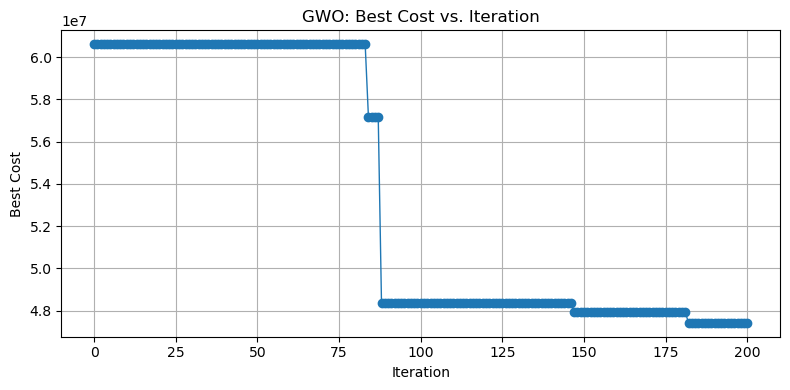

In [54]:


# --------------------------------------
# 1) PARAMETERS AND HELPERS
# --------------------------------------
α_dh, α_df, α_cf, α_p = 0.25, 0.25, 0.25, 0.25

hub_dist = {c: dist["0", c] for c in customers}

# --------------------------------------
# 2) COST FUNCTION
# --------------------------------------
def cost_of(sol):
    sol_int = np.clip(np.round(sol), 0, num_drivers - 1).astype(int)
    assigned = {d: [] for d in drivers}
    for i, drv in enumerate(sol_int):
        assigned[drivers[drv]].append(customers[i])

    total_served = total_empty = 0.0
    ratios = []
    ds_vals = []
    prio_sum = 0.0
    pen_wait = pen_cap = pen_shift = 0.0

    for d in drivers:
        route = sorted(assigned[d], key=lambda c: int(c[1:]))
        if not route:
            continue

        loop = ["0"] + route + ["0"]
        legs = [dist[loop[i], loop[i + 1]] for i in range(len(loop) - 1)]
        served = sum(legs[1:-1])
        empty = legs[0] + legs[-1]
        total_served += served
        total_empty += empty

        Dh, Pr = empty, served
        ratios.append(Pr / (Dh + 1e-6))

        accum = 0.0
        for idx, ci in enumerate(route):
            prev, cur = loop[idx], loop[idx + 1]
            dleg = dist[prev, cur]
            accum += dleg
            ds_vals.append(accum)
            prio_sum += dleg * priority[ci] / max(1e-3, accum)

        # wait-time penalty
        tacc = 0.0
        for idx, ci in enumerate(route):
            prev, cur = loop[idx], loop[idx + 1]
            tacc += time_dist[prev, cur]
            if tacc > T_max:
                pen_wait += (tacc - T_max) ** 2
            tacc += service_tm

        # shift-length penalty
        ret = time_dist[route[-1], "0"]
        if tacc + ret > shift_min:
            pen_shift += (tacc + ret - shift_min) ** 2

        # capacity penalty
        load = sum(demand[c] for c in route)
        if load > capacity:
            pen_cap += (load - capacity) ** 2

    term1 = -(total_served + total_empty)
    term2 = -np.std(ratios) if ratios else 0.0
    term3 = -np.std(ds_vals) if ds_vals else 0.0
    term4 = -prio_sum
    base = α_dh * term1 + α_df * term2 + α_cf * term3 + α_p * term4
    penalty = 1e3 * pen_wait + 1e2 * pen_cap + 1e2 * pen_shift
    return base + penalty

# --------------------------------------
# 3) GWO OPTIMIZER
# --------------------------------------
def gwo(opt_dim, pop_size=50, max_iter=100):
    X = np.random.uniform(0, num_drivers, (pop_size, opt_dim))
    costs = np.array([cost_of(x) for x in X])

    # sort and assign initial leaders
    idxs = costs.argsort()[:3]
    alpha_cost, alpha_pos = costs[idxs[0]], X[idxs[0]].copy()
    beta_cost, beta_pos = costs[idxs[1]], X[idxs[1]].copy()
    delta_cost, delta_pos = costs[idxs[2]], X[idxs[2]].copy()
    history = [alpha_cost]

    for t in range(1, max_iter + 1):
        a = 2 * (1 - t / max_iter)

        for i in range(pop_size):
            for leader in (alpha_pos, beta_pos, delta_pos):
                r1, r2 = np.random.rand(), np.random.rand()
                A_val = 2 * a * r1 - a
                C_val = 2 * r2
                D_lead = np.abs(C_val * leader - X[i])
                X[i] = X[i] - A_val * D_lead
            X[i] = np.clip(X[i], 0, num_drivers - 1)

        for i in range(pop_size):
            candidate_cost = cost_of(X[i])
            if candidate_cost < alpha_cost:
                alpha_cost, alpha_pos = candidate_cost, X[i].copy()
            elif candidate_cost < beta_cost:
                beta_cost, beta_pos = candidate_cost, X[i].copy()
            elif candidate_cost < delta_cost:
                delta_cost, delta_pos = candidate_cost, X[i].copy()

        best_so_far = min(history[-1], alpha_cost) if history else alpha_cost
        history.append(best_so_far)

    best_idx = np.clip(np.round(alpha_pos), 0, num_drivers - 1).astype(int)
    return best_idx, float(alpha_cost), history

# --------------------------------------
# 4) EXECUTION
# --------------------------------------
start = time.time()
best_sol, best_gwo_cost, history = gwo(C, pop_size=100, max_iter=200)
elapsed_gwo = time.time() - start

assign = {d: [] for d in drivers}
for i, drv in enumerate(best_sol):
    assign[drivers[drv]].append(customers[i])
used_gwo = [drv for drv, custs in assign.items() if custs]
renumbered_gwo = {f"D{new_idx}": assign[old_drv] for new_idx, old_drv in enumerate(used_gwo, start=1)}

print(f"\nGWO elapsed time: {elapsed_gwo:.2f}s")
print(f"Final GWO cost:    {best_gwo_cost:.4f}")
print(f"Drivers used: {len(renumbered_gwo)}")
print("Assignment:")
for drv, custs in renumbered_gwo.items():
    print(f"  {drv} → {custs}")

plt.figure(figsize=(8, 4))
plt.plot(history, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("GWO: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADAPTIVE GREY WOLF OPTIMIZATION ALGORITHM IMPLEMENTATION


GWO elapsed time: 47.33s

Best GWO population size: 100
Final GWO cost:    46326540.9476
Drivers used: 133
Assignment:
  D1 → ['C21']
  D2 → ['C105']
  D3 → ['C111', 'C136']
  D4 → ['C76']
  D5 → ['C91']
  D6 → ['C80']
  D7 → ['C134']
  D8 → ['C16', 'C49', 'C130']
  D9 → ['C20', 'C135', 'C180']
  D10 → ['C108']
  D11 → ['C102']
  D12 → ['C37']
  D13 → ['C84']
  D14 → ['C87', 'C170']
  D15 → ['C38', 'C74']
  D16 → ['C4']
  D17 → ['C43']
  D18 → ['C48']
  D19 → ['C52']
  D20 → ['C122', 'C178']
  D21 → ['C46']
  D22 → ['C94', 'C121', 'C179']
  D23 → ['C68', 'C133']
  D24 → ['C45', 'C192']
  D25 → ['C26', 'C51', 'C156']
  D26 → ['C159']
  D27 → ['C9']
  D28 → ['C6']
  D29 → ['C22', 'C23']
  D30 → ['C86', 'C128']
  D31 → ['C33']
  D32 → ['C145', 'C193']
  D33 → ['C60']
  D34 → ['C41', 'C54']
  D35 → ['C27']
  D36 → ['C161']
  D37 → ['C167']
  D38 → ['C175']
  D39 → ['C88', 'C107']
  D40 → ['C98', 'C173']
  D41 → ['C73']
  D42 → ['C99', 'C131']
  D43 → ['C30', 'C127']
  D44 → ['C15']
  D45 

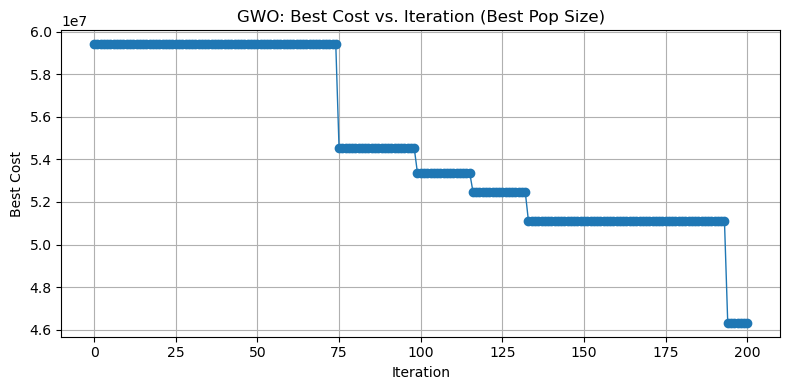

In [59]:
# --------------------------------------
# PARAMETERS AND HELPERS
# --------------------------------------
pop_sizes = [50, 100, 150]

alpha_dh, alpha_df, alpha_cf, alpha_p = 0.25, 0.25, 0.25, 0.25

hub_dist = {c: dist["0", c] for c in customers}

# --------------------------------------
# COST FUNCTION
# --------------------------------------
def cost_of(sol):
    sol_int = np.clip(np.round(sol), 0, num_drivers - 1).astype(int)
    assigned = {d: [] for d in drivers}
    for i, drv in enumerate(sol_int):
        assigned[drivers[drv]].append(customers[i])

    total_served = total_empty = 0.0
    ratios = []
    ds_vals = []
    prio_sum = 0.0
    pen_wait = pen_cap = pen_shift = 0.0

    for d in drivers:
        route = sorted(assigned[d], key=lambda c: int(c[1:]))
        if not route:
            continue

        loop = ["0"] + route + ["0"]
        legs = [dist[loop[i], loop[i + 1]] for i in range(len(loop) - 1)]
        served = sum(legs[1:-1])
        empty = legs[0] + legs[-1]
        total_served += served
        total_empty += empty

        Dh, Pr = empty, served
        ratios.append(Pr / (Dh + 1e-6))

        accum = 0.0
        for idx, ci in enumerate(route):
            prev, cur = loop[idx], loop[idx + 1]
            dleg = dist[prev, cur]
            accum += dleg
            ds_vals.append(accum)
            prio_sum += dleg * priority[ci] / max(1e-3, accum)

        tacc = 0.0
        for idx, ci in enumerate(route):
            prev, cur = loop[idx], loop[idx + 1]
            tacc += time_dist[prev, cur]
            if tacc > T_max:
                pen_wait += (tacc - T_max) ** 2
            tacc += service_tm

        ret = time_dist[route[-1], "0"]
        if tacc + ret > shift_min:
            pen_shift += (tacc + ret - shift_min) ** 2

        load = sum(demand[c] for c in route)
        if load > capacity:
            pen_cap += (load - capacity) ** 2

    term1 = -(total_served + total_empty)
    term2 = -np.std(ratios) if ratios else 0.0
    term3 = -np.std(ds_vals) if ds_vals else 0.0
    term4 = -prio_sum

    base = alpha_dh * term1 + alpha_df * term2 + alpha_cf * term3 + alpha_p * term4
    penalty = 1e3 * pen_wait + 1e2 * pen_cap + 1e2 * pen_shift
    return base + penalty

# --------------------------------------
# GWO OPTIMIZER FUNCTION
# --------------------------------------
def gwo(opt_dim, pop_size=50, max_iter=100):
    X = np.random.uniform(0, num_drivers, (pop_size, opt_dim))
    costs = np.array([cost_of(x) for x in X])

    idxs = costs.argsort()[:3]
    alpha_cost, alpha_pos = costs[idxs[0]], X[idxs[0]].copy()
    beta_cost, beta_pos = costs[idxs[1]], X[idxs[1]].copy()
    delta_cost, delta_pos = costs[idxs[2]], X[idxs[2]].copy()
    history = [alpha_cost]

    for t in range(1, max_iter + 1):
        a = 2 * (1 - t / max_iter)

        for i in range(pop_size):
            for leader in (alpha_pos, beta_pos, delta_pos):
                r1, r2 = np.random.rand(), np.random.rand()
                A_val = 2 * a * r1 - a
                C_val = 2 * r2
                D_lead = np.abs(C_val * leader - X[i])
                X[i] = X[i] - A_val * D_lead
            X[i] = np.clip(X[i], 0, num_drivers - 1)

        for i in range(pop_size):
            candidate_cost = cost_of(X[i])
            if candidate_cost < alpha_cost:
                alpha_cost, alpha_pos = candidate_cost, X[i].copy()
            elif candidate_cost < beta_cost:
                beta_cost, beta_pos = candidate_cost, X[i].copy()
            elif candidate_cost < delta_cost:
                delta_cost, delta_pos = candidate_cost, X[i].copy()

        best_so_far = min(history[-1], alpha_cost)
        history.append(best_so_far)

    best_idx = np.clip(np.round(alpha_pos), 0, num_drivers - 1).astype(int)
    return best_idx, float(alpha_cost), history

# --------------------------------------
# RUN ADAPTIVE GWO
# --------------------------------------
start = time.time()
adaptive_gwo_cost = float('inf')
best_history = None
best_assign = None
best_size = None

for pop_size in pop_sizes:
    best_sol, cost, hist = gwo(C, pop_size=pop_size, max_iter=200)
    if cost < adaptive_gwo_cost:
        adaptive_gwo_cost = cost
        best_history = hist
        best_sol_final = best_sol.copy()
        best_size = pop_size

elapsed_best_gwo = time.time() - start

assign = {d: [] for d in drivers}
for i, drv in enumerate(best_sol_final):
    assign[drivers[drv]].append(customers[i])
used_adaptive_gwo = [drv for drv, custs in assign.items() if custs]
renumbered_adaptive_gwo = {f"D{new_idx}": assign[old_drv] for new_idx, old_drv in enumerate(used_adaptive_gwo, start=1)}

print(f"\nGWO elapsed time: {elapsed_best_gwo:.2f}s")
print(f"\nBest GWO population size: {best_size}")
print(f"Final GWO cost:    {adaptive_gwo_cost:.4f}")
print(f"Drivers used: {len(renumbered_adaptive_gwo)}")
print("Assignment:")
for drv, custs in renumbered_adaptive_gwo.items():
    print(f"  {drv} → {custs}")

plt.figure(figsize=(8, 4))
plt.plot(best_history, marker='o', linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title("GWO: Best Cost vs. Iteration (Best Pop Size)")
plt.grid(True)
plt.tight_layout()
plt.show()

### FIXED VS ADAPTIVE GWO CONFIGURATION COMPARISON 

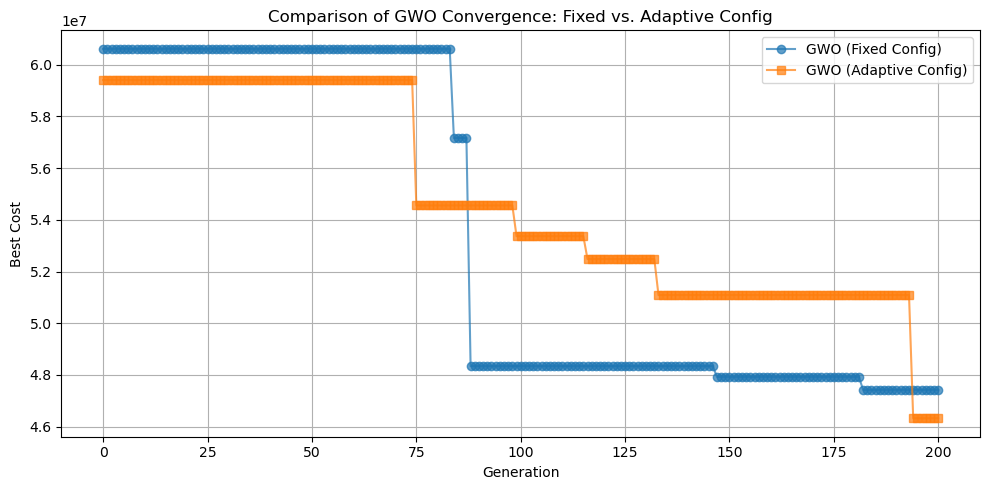

In [67]:
plt.figure(figsize=(10, 5))

# Plot original GWO curve
plt.plot(history, marker='o', linestyle='-', label='GWO (Fixed Config)', alpha=0.7)

# Plot best adaptive GWO curve
plt.plot(best_history, marker='s', linestyle='-', label='GWO (Adaptive Config)', alpha=0.7)

plt.xlabel("Generation")
plt.ylabel("Best Cost")
plt.title("Comparison of GWO Convergence: Fixed vs. Adaptive Config")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SIMULATED ANNEALING ALGORITHM IMPLEMENTATION

SA elapsed time: 0.41s
Final SA cost:  27842120.9564
Drivers used: 132
Assignment:
  D1 → ['C32', 'C63', 'C84', 'C87']
  D2 → ['C103', 'C117']
  D3 → ['C37', 'C57']
  D4 → ['C31']
  D5 → ['C51']
  D6 → ['C174']
  D7 → ['C127']
  D8 → ['C145']
  D9 → ['C122', 'C175']
  D10 → ['C131']
  D11 → ['C29', 'C161']
  D12 → ['C61', 'C120']
  D13 → ['C99', 'C134']
  D14 → ['C96', 'C119', 'C169']
  D15 → ['C47', 'C193']
  D16 → ['C62', 'C108']
  D17 → ['C70', 'C185']
  D18 → ['C85']
  D19 → ['C86']
  D20 → ['C110']
  D21 → ['C112', 'C152']
  D22 → ['C76']
  D23 → ['C27', 'C80']
  D24 → ['C81']
  D25 → ['C130', 'C136']
  D26 → ['C82']
  D27 → ['C30']
  D28 → ['C83']
  D29 → ['C3']
  D30 → ['C69']
  D31 → ['C9', 'C146']
  D32 → ['C72']
  D33 → ['C94']
  D34 → ['C15', 'C98']
  D35 → ['C97']
  D36 → ['C53', 'C170']
  D37 → ['C56', 'C93']
  D38 → ['C100', 'C177']
  D39 → ['C11', 'C50']
  D40 → ['C187']
  D41 → ['C179']
  D42 → ['C77', 'C102']
  D43 → ['C21', 'C183']
  D44 → ['C140', 'C163']
  D45 → ['C

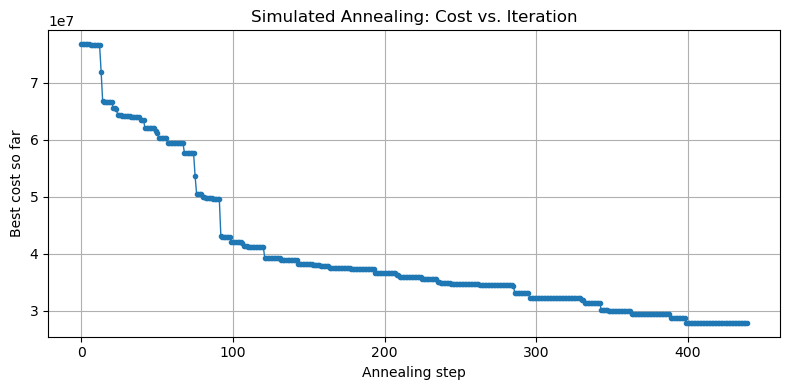

In [60]:


# ------------------------------------
# PROBLEM DEFINITION
# ------------------------------------
class DeliveryProblem(ProblemBase):
    def __init__(self):
        self.customers = customers
        self.drivers   = drivers
        # data maps
        self.dist       = dist
        self.time_      =  time_dist
        self.demand     = demand
        self.priority   = priority
        self.wait_time  = wait_time
        self.T_max      = T_max
        self.service_tm = service_tm
        self.shift_min  = shift_min
        self.capacity   = capacity
        # weights
        self.α_dh = 0.25
        self.α_df = 0.25
        self.α_cf = 0.25
        self.α_p  = 0.25

    def get_init_solution(self):
        # random assignment of each customer to one of the D drivers
        return [random.randrange(len(self.drivers))
                for _ in self.customers]

    def get_neighbour_solution(self, sol):
        # tweak a single customer's assignment
        neighbor = sol.copy()
        i = random.randrange(len(neighbor))
        neighbor[i] = random.randrange(len(self.drivers))
        return neighbor

    def eval_solution(self, sol):
        # build per-driver route lists
        assigned = {d: [] for d in self.drivers}
        for idx, drv in enumerate(sol):
            assigned[self.drivers[drv]].append(self.customers[idx])

        total_served = total_empty = 0.0
        ratios = []   # Pr_j / Dh_j
        ds_vals = []  # each customer‘s ds_i
        prio_sum = 0.0

        # hard-penalty accumulators
        pen_wait  = pen_shift = pen_cap = 0.0

        for d in self.drivers:
            route = assigned[d]
            if not route:
                continue

            # **sort** to break ties
            route_sorted = sorted(route, key=lambda c: int(c[1:]))

            # full loop: depot→c1→…→cN→depot
            loop = ["0"] + route_sorted + ["0"]
            legs = [self.dist[loop[i], loop[i+1]]
                    for i in range(len(loop)-1)]
            served_dist = sum(legs[1:-1])
            empty_dist  = legs[0] + legs[-1]
            total_served += served_dist
            total_empty  += empty_dist

            # term2
            Dh_j = empty_dist
            Pr_j = served_dist
            ratios.append(Pr_j / (Dh_j+1e-6))

            # term3 & term4 internals
            accum = 0.0
            for idx, ci in enumerate(route_sorted):
                prev, curr = loop[idx], loop[idx+1]
                leg = self.dist[prev, curr]
                accum += leg
                ds_vals.append(accum)
                prio_sum += leg * self.priority[ci] / max(1e-3, accum)

            # WAIT-TIME penalty
            t_elapsed = 0.0
            for idx, ci in enumerate(route_sorted):
                prev, curr = loop[idx], loop[idx+1]
                t_elapsed += self.time_[prev, curr]
                if t_elapsed > self.T_max:
                    pen_wait += (t_elapsed - self.T_max)**2
                t_elapsed += self.service_tm

            # SHIFT-LENGTH penalty (include return leg)
            return_leg = self.time_[route_sorted[-1], "0"]
            if t_elapsed + return_leg > self.shift_min:
                pen_shift += (t_elapsed + return_leg - self.shift_min)**2

            # CAPACITY penalty
            load = sum(self.demand[c] for c in route_sorted)
            if load > self.capacity:
                pen_cap += (load - self.capacity)**2

        # assemble the four objective terms
        term1 = -(total_served + total_empty)
        term2 = -np.std(ratios)   if ratios  else 0.0
        term3 = -np.std(ds_vals)  if ds_vals else 0.0
        term4 = -prio_sum

        f = ( self.α_dh*term1
            + self.α_df*term2
            + self.α_cf*term3
            + self.α_p *term4 )

        # add big penalties to enforce all constraints
        penalty = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift

        return f + penalty

# ------------------------------------
# LOGGING SA SUBCLASS
# ------------------------------------
cost_history = []

class LoggingSA(SimulatedAnnealing):
    def annealing_step(self):
        res = super().annealing_step()
        cost_history.append(self.val_best)
        return res

# ------------------------------------
# SETUP & RUN
# ------------------------------------
problem = DeliveryProblem()

sa = LoggingSA(
    max_iter=200,               # total temperature steps
    max_iter_per_temp=5,        # inner loops per temperature
    initial_temp=1000.0,
    final_temp=0.1,
    cooling_schedule='geometric',
    cooling_alpha=0.9,
    debug=0
)

start = time.time()
sa.run(problem_obj=problem)
elapsed_sa = time.time() - start

# decode best
best_sol  = sa.s_allbest
best_sa_cost = sa.val_allbest

assign = {d:[] for d in drivers}
for i,drv in enumerate(best_sol):
    assign[drivers[drv]].append(customers[i])
# 1) collect only the drivers that actually have customers
used_sa = [drv for drv, custs in assignment.items() if custs]

# 2) build a new, renumbered dict
renumbered_sa = {}
for new_idx, old_drv in enumerate(used_sa, start=1):
    renumbered_sa[f"D{new_idx}"] = assignment[old_drv]

# ------------------------------------
# REPORT & PLOT
# ------------------------------------
print(f"SA elapsed time: {elapsed_sa:.2f}s")
print(f"Final SA cost:  {best_sa_cost:.4f}")
print(f"Drivers used: {len(renumbered_sa)}")
print("Assignment:")
for drv, custs in renumbered_sa.items():
    print(f"  {drv} → {custs}")

plt.figure(figsize=(8,4))
plt.plot(cost_history, marker='.', linewidth=1)
plt.xlabel("Annealing step")
plt.ylabel("Best cost so far")
plt.title("Simulated Annealing: Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADAPTIVE SIMULATED ANNEALING ALGORITHM IMPLEMENTATION


SA elapsed time: 4.08s
Best SA Config: T0=100, Tmin=0.1, alpha=0.9
Final SA cost:  26948186.5779
Drivers used: 159
Assignment:
  D1 → ['C70']
  D2 → ['C37']
  D3 → ['C40']
  D4 → ['C65']
  D5 → ['C12']
  D6 → ['C38']
  D7 → ['C57']
  D8 → ['C104']
  D9 → ['C45', 'C119']
  D10 → ['C155']
  D11 → ['C165']
  D12 → ['C21']
  D13 → ['C83']
  D14 → ['C171']
  D15 → ['C73', 'C75']
  D16 → ['C161']
  D17 → ['C52']
  D18 → ['C68']
  D19 → ['C108']
  D20 → ['C120']
  D21 → ['C77']
  D22 → ['C93']
  D23 → ['C190']
  D24 → ['C86']
  D25 → ['C1', 'C166']
  D26 → ['C175']
  D27 → ['C106']
  D28 → ['C24']
  D29 → ['C111']
  D30 → ['C94']
  D31 → ['C55']
  D32 → ['C11', 'C110']
  D33 → ['C148']
  D34 → ['C99']
  D35 → ['C121']
  D36 → ['C62', 'C98']
  D37 → ['C20', 'C48']
  D38 → ['C82']
  D39 → ['C23']
  D40 → ['C31']
  D41 → ['C135']
  D42 → ['C47']
  D43 → ['C97', 'C139']
  D44 → ['C25', 'C27']
  D45 → ['C113']
  D46 → ['C35', 'C54', 'C112']
  D47 → ['C188']
  D48 → ['C17']
  D49 → ['C89']
  D50 →

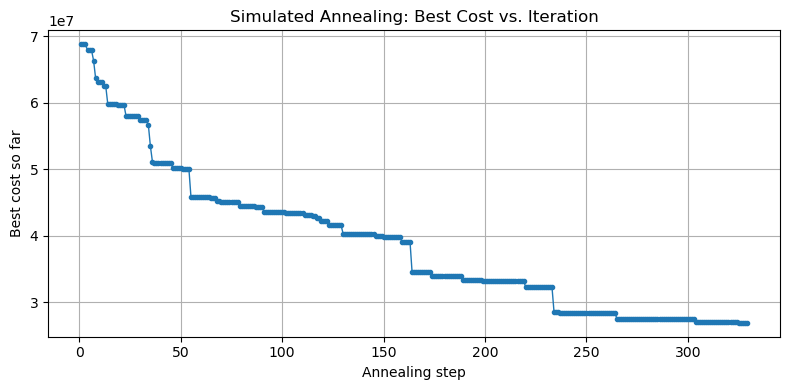

In [61]:

# ------------------------------------
# PROBLEM DEFINITION
# ------------------------------------
class DeliveryProblem(ProblemBase):
    def __init__(self):
        self.customers = customers
        self.drivers   = drivers
        self.dist       = dist
        self.time_      =  time_dist
        self.demand     = demand
        self.priority   = priority
        self.wait_time  = wait_time
        self.T_max      = T_max
        self.service_tm = service_tm
        self.shift_min  = shift_min
        self.capacity   = capacity
        self.α_dh = 0.25
        self.α_df = 0.25
        self.α_cf = 0.25
        self.α_p  = 0.25

    def get_init_solution(self):
        return [random.randrange(len(self.drivers)) for _ in self.customers]

    def get_neighbour_solution(self, sol):
        neighbor = sol.copy()
        i = random.randrange(len(neighbor))
        neighbor[i] = random.randrange(len(self.drivers))
        return neighbor

    def eval_solution(self, sol):
        assigned = {d: [] for d in self.drivers}
        for idx, drv in enumerate(sol):
            assigned[self.drivers[drv]].append(self.customers[idx])

        total_served = total_empty = 0.0
        ratios = []
        ds_vals = []
        prio_sum = 0.0
        pen_wait = pen_shift = pen_cap = 0.0

        for d in self.drivers:
            route = assigned[d]
            if not route:
                continue
            route_sorted = sorted(route, key=lambda c: int(c[1:]))
            loop = ["0"] + route_sorted + ["0"]
            legs = [self.dist[loop[i], loop[i+1]] for i in range(len(loop)-1)]
            served_dist = sum(legs[1:-1])
            empty_dist  = legs[0] + legs[-1]
            total_served += served_dist
            total_empty  += empty_dist
            Dh_j = empty_dist
            Pr_j = served_dist
            ratios.append(Pr_j / (Dh_j+1e-6))

            accum = 0.0
            for idx, ci in enumerate(route_sorted):
                prev, curr = loop[idx], loop[idx+1]
                leg = self.dist[prev, curr]
                accum += leg
                ds_vals.append(accum)
                prio_sum += leg * self.priority[ci] / max(1e-3, accum)

            t_elapsed = 0.0
            for idx, ci in enumerate(route_sorted):
                prev, curr = loop[idx], loop[idx+1]
                t_elapsed += self.time_[prev, curr]
                if t_elapsed > self.T_max:
                    pen_wait += (t_elapsed - self.T_max)**2
                t_elapsed += self.service_tm

            return_leg = self.time_[route_sorted[-1], "0"]
            if t_elapsed + return_leg > self.shift_min:
                pen_shift += (t_elapsed + return_leg - self.shift_min)**2

            load = sum(self.demand[c] for c in route_sorted)
            if load > self.capacity:
                pen_cap += (load - self.capacity)**2

        term1 = -(total_served + total_empty)
        term2 = -np.std(ratios) if ratios else 0.0
        term3 = -np.std(ds_vals) if ds_vals else 0.0
        term4 = -prio_sum
        f = ( self.α_dh*term1 + self.α_df*term2 + self.α_cf*term3 + self.α_p *term4 )
        penalty = 1e3*pen_wait + 1e2*pen_cap + 1e2*pen_shift
        return f + penalty

# ------------------------------------
# LOGGING SA SUBCLASS
# ------------------------------------
class LoggingSA(SimulatedAnnealing):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []
        self.elapsed_time = 0

    def run(self, problem_obj):
        start = time.time()
        super().run(problem_obj)
        self.elapsed_time = time.time() - start

    def annealing_step(self):
        res = super().annealing_step()
        self.history.append(self.val_best)
        return res

# ------------------------------------
# ADAPTIVE SETUP & RUN
# ------------------------------------
start = time.time()
T0s = [100, 500, 1000]
Tmins = [1e-1, 1.0]
alphas = [0.80, 0.85, 0.90]

best_cost = float('inf')
best_config = None
best_sa = None

problem = DeliveryProblem()

for T0 in T0s:
    for Tmin in Tmins:
        for alpha in alphas:
            sa = LoggingSA(
                max_iter=200,
                max_iter_per_temp=5,
                initial_temp=T0,
                final_temp=Tmin,
                cooling_schedule='geometric',
                cooling_alpha=alpha,
                debug=0
            )
            sa.run(problem_obj=problem)
            if sa.val_allbest < best_cost:
                best_cost = sa.val_allbest
                best_config = (T0, Tmin, alpha)
                best_sa = sa

elapsed_best_sa = time.time() - start

# decode best
best_sol = best_sa.s_allbest
adaptive_sa_cost = best_sa.val_allbest

assign = {d: [] for d in drivers}
for i, drv in enumerate(best_sol):
    assign[drivers[drv]].append(customers[i])
used_adaptive_sa = [drv for drv, custs in assign.items() if custs]
renumbered_adaptive_sa = {f"D{new_idx}": assign[old_drv] for new_idx, old_drv in enumerate(used_adaptive_sa, start=1)}

# ------------------------------------
# REPORT & PLOT
# ------------------------------------
print(f"\nSA elapsed time: {elapsed_best_sa:.2f}s")
print(f"Best SA Config: T0={best_config[0]}, Tmin={best_config[1]}, alpha={best_config[2]}")
print(f"Final SA cost:  {adaptive_sa_cost:.4f}")
print(f"Drivers used: {len(renumbered_adaptive_sa)}")
print("Assignment:")
for drv, custs in renumbered_adaptive_sa.items():
    print(f"  {drv} → {custs}")

plt.figure(figsize=(8,4))
plt.plot(best_sa.history, marker='.', linewidth=1)
plt.xlabel("Annealing step")
plt.ylabel("Best cost so far")
plt.title("Simulated Annealing: Best Cost vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

### FIXED VS ADAPTIVE SA CONFIGURATION COMPARISON 

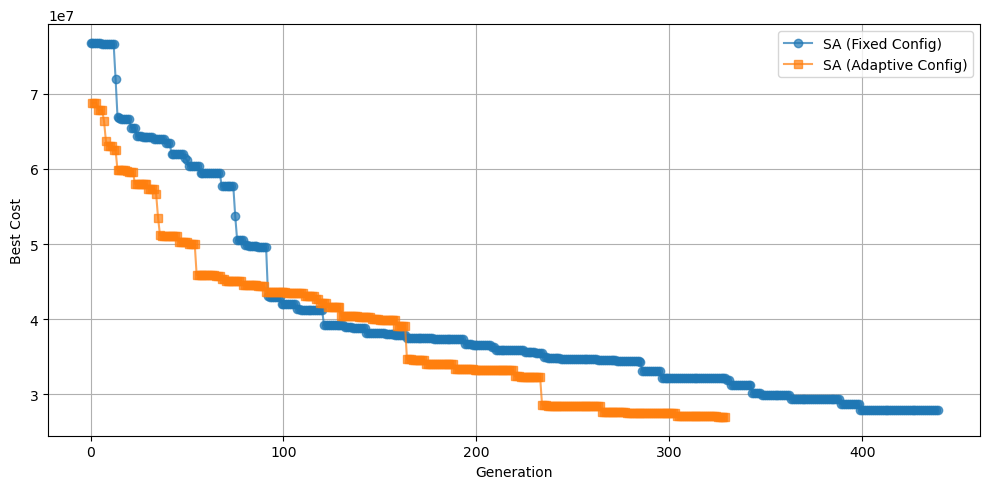

In [62]:
plt.figure(figsize=(10, 5))

# Plot original SA curve
plt.plot(cost_history, marker='o', linestyle='-', label='SA (Fixed Config)', alpha=0.7)

# Plot best adaptive SA curve
plt.plot(best_sa.history, marker='s', linestyle='-', label='SA (Adaptive Config)', alpha=0.7)

plt.xlabel("Generation")
plt.ylabel("Best Cost")
# plt.title("Comparison of SA Convergence: Fixed vs. Adaptive Config")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### FINAL RESULT VISUALIZATION

In [69]:
df_summary = pd.DataFrame({
    "Algorithm":      ["GA", "Adaptive GA", "PSO", "Adaptive PSO",  "AO", "Adaptive AO", "GWO",   "Adaptive GWO", "SA",  "Adaptive SA"],
    "Solve Time (s)": [elapsed_ga, elapsed_best_ga, elapsed_pso, elapsed_best_ga,  elapsed_ao, elapsed_best_ao, elapsed_gwo, elapsed_best_gwo, elapsed_sa, elapsed_best_sa],
    "Best Cost":      [best_ga_cost, adaptive_ga_cost, best_pso_cost, adaptive_pso_cost, best_ao_cost,  adaptive_ao_cost, best_gwo_cost,  adaptive_gwo_cost, best_sa_cost, adaptive_sa_cost],
    "Drivers Used":   [len(renumbered_ga),len(renumbered_adaptive_ga), len(renumbered_pso),len(renumbered_adaptive_pso), len(renumbered_ao),len(renumbered_adaptive_ao), len(renumbered_gwo),len(renumbered_adaptive_gwo), len(renumbered_sa),len(renumbered_adaptive_sa),]
})

print(df_summary.to_string(index=False))

   Algorithm  Solve Time (s)    Best Cost  Drivers Used
          GA       37.645257 2.635486e+07           153
 Adaptive GA       50.445474 2.517712e+07           157
         PSO       10.021615 5.878770e+07           129
Adaptive PSO       50.445474 3.831539e+07           124
          AO       14.960036 5.271780e+07           129
 Adaptive AO      136.008957 4.331808e+07           132
         GWO       14.456303 4.742583e+07           129
Adaptive GWO       47.325930 4.632654e+07           133
          SA        0.409209 2.784212e+07           132
 Adaptive SA        4.076173 2.694819e+07           159


### OSMNX ROUTE VISUALIZATION

C:\Users\DELL\anaconda3\Lib\site-packages\osmnx\plot.py:348: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


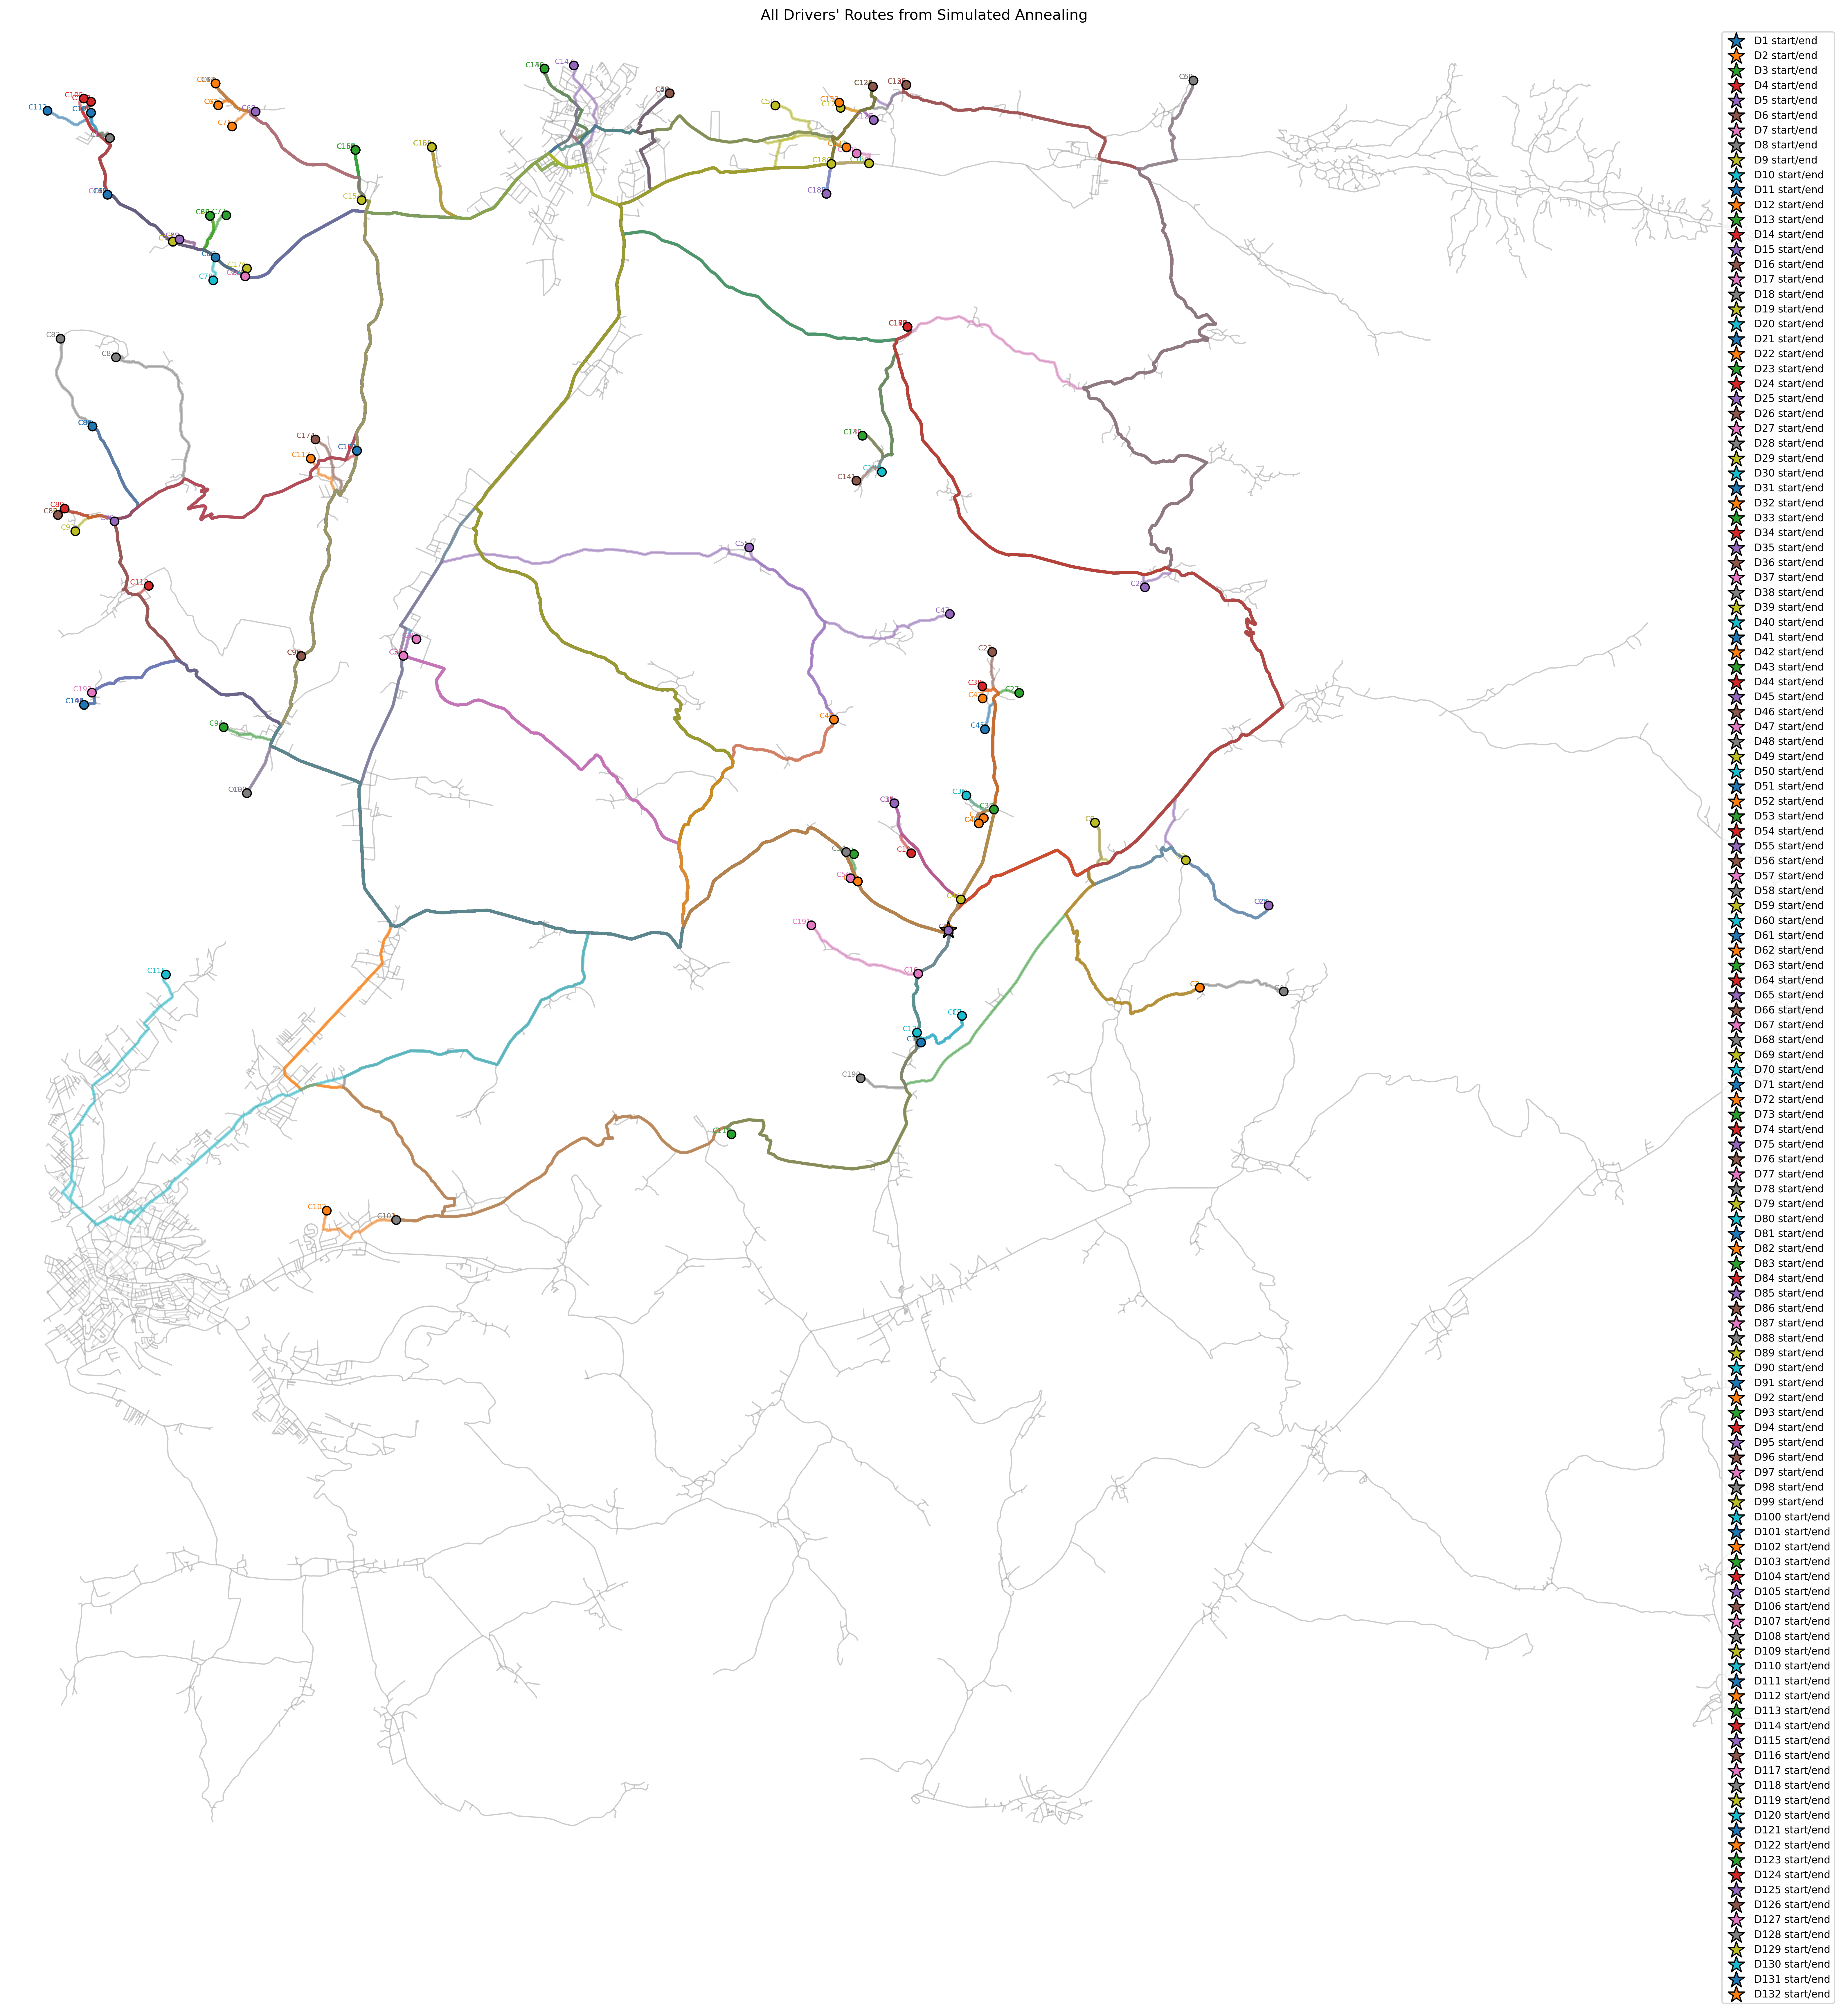

In [71]:
import openrouteservice
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math

# Load data
df = pd.read_csv('DeliveryDataset2.csv')

# Set your OpenRouteService API key here
ors_client = openrouteservice.Client(key='5b3ce3597851110001cf6248693af50d08604b6284270544186cb668')

# Generate customer ID labels like 'C1', 'C2', ...
df['CustomerLabel'] = ['C' + str(i+1) for i in range(len(df))]

nodes = ['0'] + df.CustomerLabel.tolist()

# Construct coordinate dictionary with consistent keys
coords = {'0': (df.lat[0], df.lon[0])}
for i, row in df.iterrows():
    coords['C' + str(i+1)] = (row.lat, row.lon)

# Function to compute batch distance and time matrices
def batch_distance_matrix(client, locations, batch_size=50):
    num_locations = len(locations)
    distance_matrix = np.zeros((num_locations, num_locations))
    time_matrix = np.zeros((num_locations, num_locations))

    for i in range(0, num_locations, batch_size):
        for j in range(0, num_locations, batch_size):
            sources = list(range(i, min(i+batch_size, num_locations)))
            destinations = list(range(j, min(j+batch_size, num_locations)))

            sub_matrix = client.distance_matrix(
                locations=locations,
                profile='driving-car',
                sources=sources,
                destinations=destinations,
                metrics=['distance', 'duration'],
                units='km'
            )

            for s_idx, s in enumerate(sources):
                for d_idx, d in enumerate(destinations):
                    distance_matrix[s, d] = sub_matrix['distances'][s_idx][d_idx]
                    time_matrix[s, d] = sub_matrix['durations'][s_idx][d_idx] / 60.0

    return distance_matrix, time_matrix

# Prepare coordinates for batch processing
locations = [coords[node][::-1] for node in nodes]  # ORS requires lon-lat format

# Get matrices in batches
distance_matrix, time_matrix = batch_distance_matrix(ors_client, locations)

# Convert to dictionary format
dist_dict = {}
time_dict = {}
for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        dist_dict[(u, v)] = distance_matrix[i][j]
        time_dict[(u, v)] = time_matrix[i][j]

# SA assignment for visualization
assignment = renumbered_sa

# Build location dictionaries for visualization
cust_locs = { row.CustomerLabel:(row.lat, row.lon) for _, row in df.iterrows() }
hub_lat, hub_lon = coords['0']

def distance(a, b):
    lat1, lon1 = a; lat2, lon2 = b
    R = 6371
    dlat, dlon = math.radians(lat2-lat1), math.radians(lon2-lon1)
    h = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(h), math.sqrt(1-h))

max_dist_km = max(distance((hub_lat, hub_lon), loc) for loc in cust_locs.values())
radius_m = (max_dist_km + 1) * 700

G = ox.graph_from_point((hub_lat, hub_lon), dist=radius_m, network_type="drive")

hub_node = ox.distance.nearest_nodes(G, hub_lon, hub_lat)
cust_nodes = {
    cid: ox.distance.nearest_nodes(G, lon, lat)
    for cid, (lat, lon) in cust_locs.items()
}

pos = { n:(data['x'],data['y']) for n,data in G.nodes(data=True) }
colors = plt.cm.tab10.colors

# Plot all drivers' routes in one graph
fig, ax = plt.subplots(figsize=(25,25), dpi= 300)
ox.plot_graph(G, ax=ax, show=False, close=False, node_size=0, edge_color="#999999", edge_alpha=0.3)

for driver_idx, (drv, route_cids) in enumerate(assignment.items()):
    if not route_cids:
        continue  # skip empty assignments
    col = colors[driver_idx % len(colors)]
    try:
        start_node = hub_node  # start and end at the actual depot
    except KeyError:
        print(f"Warning: hub_node not found. Skipping {drv}.")
        continue

    prev = start_node
    full_route = []

    try:
        for cid in route_cids:
            nxt = cust_nodes[cid]
            leg = nx.shortest_path(G, prev, nxt, weight="length")
            full_route.extend(leg if not full_route else leg[1:])
            prev = nxt

        back = nx.shortest_path(G, prev, hub_node, weight="length")
        full_route.extend(back[1:])

        if not full_route:
            continue

        ox.plot_graph_route(G, full_route, ax=ax, route_color=col, route_linewidth=2.5, show=False, close=False)

        x0, y0 = pos[hub_node]
        ax.scatter([x0], [y0], c=[col], marker="*", s=200, label=f"{drv} start/end", zorder=5, edgecolor="k")

        xs, ys = [], []
        for cid in route_cids:
            node = cust_nodes[cid]
            x, y = pos[node]
            xs.append(x); ys.append(y)
        ax.scatter(xs, ys, c=[col], s=50, marker="o", zorder=6, edgecolor="k")

        for cid in route_cids:
            x, y = pos[cust_nodes[cid]]
            ax.text(x, y, cid, fontsize=6, ha="right", va="bottom", color=col)

    except Exception as e:
        print(f"Error plotting route for {drv}: {e}")

ax.legend(loc="upper right", fontsize="small")
ax.set_title("All Drivers' Routes from Simulated Annealing")
ax.set_axis_off()
plt.tight_layout()
plt.show()